# 一、添加必要的库

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# 二、全局变量

## 1.一些量的map

### （1）开关状态

In [2]:
ON = True
OFF = False

### （2）虚拟电池模型参数的index

In [3]:
CIDX = 0            # 电池容量的index
P_chargeIDX = 1     # 充电功率的～
P_dischargeIDX = 2  # 放电功率的～
alphaIDX = 3        # 耗散系数的～

## 2.超参数

In [4]:
NumTCL = 1000       # 空调的数量
t_span = 3600       # 仿真的时长/s
h = 0.1             # 仿真的时间步长/s
Amplifier = 500    # 对AGC信号（-1到1）的放大/kW
ONOFF = np.random.choice([ON, OFF], size=NumTCL)    # 在某一时刻空调集群的开关状态

## 3.空调参数

<div align="center">

| Parameter   | Description               | Value | Unit       |
|------------|---------------------------|-------|------------|
| $C_{th}$    | thermal capacitance        | 2     | kWh/°C     |
| $R_{th}$    | thermal resistance         | 2     | °C/kW      |
| $P_{m}$     | rated electrical power     | 5.6   | kW         |
| $\eta$      | coefficient of performance | 2.5   | –          |
| $\theta_{r}$| temperature setpoint       | 22.5  | °C         |
| $\Delta$    | temperature deadband       | 0.3   | °C         |

</div>

In [5]:
CthIDX, Cth = 0, 2          # 热容：kWh/Celsus
RthIDX, Rth = 1, 2          # 热阻：Celsus/kW
PmIDX,  Pm  = 2, 5.6        # 工作功率：kW
etaIDX, eta = 3, 2.5        # 电-热转换效率：none
TrIDX,  Tr  = 4, 22.5       # 设定温度：Celsus
TdeltaIDX, Tdelta = 5, 0.3  # 温度死区
PoIDX = 6                   # 平均功率的index
Ta = 32                     # 环境温度：Celsus
# T0 = np.random.uniform(low=0.95*Tr, high=1.05*Tr, size=NumTCL) # 按照高斯初始化房间温度

# 二、函数定义

## 1.微分方程相关函数

### （1）温度微分方程

$$
\dot{\theta}(t) = 
\begin{cases}
-a \left( \theta(t) - \theta_a \right) - b P_m, & \text{if } q(t) = 1, \\
-a \left( \theta(t) - \theta_a \right), & \text{if } q(t) = 0.
\end{cases}
$$

In [6]:
def dTheta(q, Tt, a, b, Pm, Ta=Ta):
    return -a * (Tt - Ta) - (b * Pm if q == ON else 0)

### （2）计算参数


> 参数可以用class来优化，避免index。现在工作太多，等之后有机会优化

$$
a = \frac{1}{R_{th} C_{th}}, \quad b = \frac{\eta}{C_{th}}
$$


$$
P_o \approx P_a = \frac{P_m T_{\text{ON}}}{T_{\text{ON}} + T_{\text{OFF}}}
$$
$$
T_{\text{ON}} = R_{th} C_{th} \ln \left( 
\frac{\theta_r + \Delta - \theta_a + R_{th} P_m \eta}
     {\theta_r - \Delta - \theta_a + R_{th} P_m \eta}
\right),
$$

$$
T_{\text{OFF}} = R_{th} C_{th} \ln \left( 
\frac{\theta_r - \Delta - \theta_a}
     {\theta_r + \Delta - \theta_a}
\right).
$$

返回参数 Paras = [Cth, Rth, Pm, eta, Tr, Tdelta, Po]，一共7个

In [7]:
def ParaCreate(Cth=Cth, Rth=Rth, Pm=Pm, eta=eta, Tr=Tr, Tdelta=Tdelta):
    global T0

    # 单个空调的6个参数
    params = [Cth, Rth, Pm, eta, Tr, Tdelta]

    # params为中心值，正态分布地创建NumTCL组参数
    Paras = [np.random.uniform(low=0.95*para, high=1.05*para, size=NumTCL) for para in params]

    # 计算平均功率Po
    Ton = Paras[RthIDX] * Paras[CthIDX] * np.log((Paras[TrIDX]+Paras[TdeltaIDX]-Ta+Paras[RthIDX]*Paras[PmIDX]*Paras[etaIDX])\
                                                  /(Paras[TrIDX]-Paras[TdeltaIDX]-Ta+Paras[RthIDX]*Paras[PmIDX]*Paras[etaIDX]))
    Toff = Paras[RthIDX] * Paras[CthIDX] * np.log((Paras[TrIDX]-Paras[TdeltaIDX]-Ta)\
                                                   /(Paras[TrIDX]+Paras[TdeltaIDX]-Ta))
    array = Paras[PmIDX] * Ton / (Ton + Toff)
    Paras.append(array)

    T0 = Paras[TrIDX] # 房间温度从设定温度开始，保持模型稳定

    return Paras

### （3）欧拉法

输入:初始值y，参数矩阵para，空调序号n

输出：下一个时间步的值y'

In [8]:
def euler_step_temp(y, para, n):
    Rth = para[RthIDX][n]
    Cth = para[CthIDX][n]
    eta = para[etaIDX][n]
    Pm = para[PmIDX][n]
    
    # a和b的定义在之前讲过
    a = 1/(Rth * Cth * 3600)
    b = eta / (Cth * 3600)
    
    return y + h * dTheta(q=ONOFF[n], Tt=y, a=a, b=b, Pm=Pm) # 欧拉法的微分方程

## 2.调节信号AGC导入

<div align="center">

xlsx中一个sheet的格式：
|            | 2024/8/1       | 2024/8/2       | 2024/8/3       |
|------------|----------------|----------------|----------------|
| 0:00:00    | -0.060887777   | -0.677524341   | 0.208261484    |
| 0:00:02    | -0.022711425   | -0.618547781   | 0.203225562    |
| 0:00:04    | 0.005852098    | -0.576672595   | 0.201201917    |
| 0:00:06    | 0.031228931    | -0.562537644   | 0.201750942    |
| 0:00:08    | 0.049184433    | -0.553388369   | 0.205338368    |
| 0:00:10    | 0.062558913    | -0.502720276   | 0.212600386    |

</div>

In [9]:
def ImportAGC():
    file_path = 'data/rto-regulation-signal-08-2024.xlsx'
    sheet_name = 'Dynamic'
    data = pd.read_excel(file_path, sheet_name)

    # 取“第1列（去掉时间列），所有行”的调节信号
    # 把信号放大到Amplifier数量级
    return np.array([data * Amplifier for data in data.iloc[1000:, 1].to_list()])

## 3.虚拟电池模型

<div align="center">

|       参数           | (必要模型) Battery $\mathbb{B}(\phi_2)$       |（充分模型）Battery $\mathbb{B}(\phi_1)$，使$n_-$最大|（充分模型）Battery $\mathbb{B}(\phi_1)$，使$n_+$最大|（充分模型）Battery $\mathbb{B}(\phi_1)$，使$C$最大|
|----------------------|----------------------------------------------------------------------|------|--|--|
| $C$    | $\sum_k \left(1 + \left\lvert 1 - \dfrac{a^k}{\alpha} \right\lvert \right) \dfrac{\Delta^k}{b^k}$ |$(\sum_k P_o^k) \min_k \dfrac{f^k}{P_o^k}$|$\left( \sum_k P_m^k - P_o^k \right) \min_k \left( \dfrac{f^k}{P_m^k - P_o^k} \right)$|$\sum_k f^k$|
| $n_-$                | $\sum_k P_o^k$                  |$\sum_k P_o^k$|$\left( \sum_k P_m^k - P_o^k \right) \min_k \left( \dfrac{P_o^k}{P_m^k - P_o^k} \right)$|$\left( \sum_k f^k \right) \min_k \left( \dfrac{P_o^k}{f^k} \right)$|
| $n_+$                | $\sum_k P_m^k - P_o^k$          |$(\sum_k P_o^k) \min_k \dfrac{P_m^k - P_o^k}{P_o^k}$|$\sum_k P_m^k - P_o^k$|$\left( \sum_k f^k \right) \min_k \left( \dfrac{P_m^k - P_o^k}{f^k} \right)$|


其中
</div>

$$
f^k = \dfrac{\Delta^k}{b^k \left(1 + \left| \dfrac{\alpha - a^k}{a^k} \right| \right)}.
$$



In [10]:
def BatteryModel(para):
    # 必要模型
    # 充放电功率
    P_discharge =  -sum(para[PoIDX])
    P_charge = (sum(para[PmIDX]) - sum(para[PoIDX]))  
    
    # 容量
    Rth = para[RthIDX]
    Cth = para[CthIDX]
    eta = para[etaIDX]
    T_delta = para[TdeltaIDX]
    a = 1/(Rth * Cth * 3600)
    b = eta / (Cth * 3600)
    alpha = np.average(a)
    C = sum((1 + abs(1 - a/alpha))*T_delta/b) / 3600    # a和b中的时间单位为s，为使C为kwh，故/3600

    # 必要模型的4个参数
    B_necessary = [C, P_charge, P_discharge, alpha]     

    # 使放电功率n_-最大的充分模型
    # 充放电功率
    P_discharge = -sum(para[PoIDX])
    P_charge = -P_discharge * min((para[PmIDX] - para[PoIDX])/para[PoIDX])   

    # 容量
    f = T_delta/(b*(1 + abs(alpha/a - 1)))
    C = -P_discharge * min(f/para[PoIDX]) / 3600        # 从kWs转换到kWh

    # 充分模型的4个参数
    # P_charge = np.float64(2000.0)   # 必要模型的充电功率算出来和论文不一致，故手动设为一致
    B_sufficient = [C, P_charge, P_discharge, alpha]

    return B_necessary, B_sufficient

## 4.初始化

In [11]:
def init_var():
    global ts, Ts, Ps, ONOFFs
    ts = np.arange(start=0, stop=t_span, step=h)    # 仿真时长/仿真步长=仿真步数
    Ts = np.zeros(shape=[len(ts), NumTCL])          # Ts[i,j]表示第j台空调在第i个时间步时的温度
    Ps = np.zeros(shape=t_span // 4)                # Ps[i]表示第4*i秒时调节信号与空调集群偏移功率的差值
    ONOFFs = np.tile(ONOFF, (len(Ps), 1))           # ONOFFs[i,j]表示第i台空调在第4*j秒时的开关状态
    Ts[0] = T0                                      # 空调集群初始温度

## 5.空调控制函数（优先堆栈算法）

<div align="center">
<img src=".attachments/Screenshot 2025-06-03 at 9.47.00 PM.png" alt="示例图片" width="500px" />
</div>

<div align="center">
<img src=".attachments/WX20250603-102803 PM@2x.png" width="500px"/>
</div>


In [12]:
def control(i, control_idx, agc, para, ONOFF):
    """
    i（int）：在第i个时间步进行控制
    control_idx（int）：Ps数组中的index。
    agc：第i个时间步的控制信号。AGC数组数据之间相隔2s
    para：6个参数
    ONOFF：第i-1时间步，空调集群的开关状态
    """
    # 使用必要模型控制，满足每个空调的温度要求
    within_band = np.array((Ts[i - 1] >= para[TrIDX] - para[TdeltaIDX]/2) & 
                           (Ts[i - 1] <= para[TrIDX] + para[TdeltaIDX]/2))  # 每台空调的温度是否在范围内
    above_band = np.array(Ts[i-1] > para[TrIDX] + para[TdeltaIDX]/2)        # 每台空调的温度是否超过上限
    below_band = np.array(Ts[i-1] < para[TrIDX] - para[TdeltaIDX]/2)        # 每台空调的温度是否超过下限

    # 初步控制：改变把温度过限的空调状态
    # 这些空调和band的状态没有改变，因此不会参与下面的stack
    ONOFF[above_band] = ON      # 把温度过高的空调打开
    ONOFF[below_band] = OFF     # 把温度过低的空调关闭

    # 计算虚拟电池的充电功率
    P_delta = sum(para[PmIDX][ONOFF == ON]) - sum(para[PoIDX])

    # 建立一个stack
    if P_delta <= agc:
        # 增加充电功率，需要建立关闭的空调的stack
        charge = True      
        mask = (ONOFF == OFF) & within_band                     # 在满足温度范围的空调群内寻找关闭的空调
        Tdiff = (para[TrIDX] + para[TdeltaIDX]/2 - Ts[i - 1])\
                /para[TdeltaIDX]                                # 温度上限-空调温度，越小说明越紧迫
        candidates = np.where(mask, Tdiff, +np.inf)            # 把非目标空调的值变最大，即最不紧迫
        sorted_indices = np.argsort(candidates)                 # 从小到大排序
    else:
        # 减少充电功率，需要建立打开的空调的stack
        charge = False
        mask = (ONOFF == ON) & within_band                      # 在满足温度范围的空调群内寻找关闭的空调
        Tdiff = (Ts[i - 1] - (para[TrIDX] - para[TdeltaIDX]/2))\
                /para[TdeltaIDX]                                # 空调温度-温度下限，越小说明越紧迫
        candidates = np.where(mask, Tdiff, +np.inf)            # 把非目标空调的值变最大，即最不紧迫
        sorted_indices = np.argsort(candidates)                 # 从小到大排序

    # 根据stack来开关空调，直到P_delta与agc的大小关系变化
    for idx in sorted_indices:
        if mask[idx] == False:  # 跳过不在控制范围内的空调
            continue
        P_delta += para[PmIDX][idx] * 1 if charge == True else -1   # 打开或关闭这台空调
        ONOFF[idx] = ON if charge == True else OFF                  # 空调状态取反
        stop = P_delta >= agc if charge == True else P_delta <= agc # 当P_delta满足agc的要求
        if stop:
            break

    Ps[control_idx] = agc - P_delta     # AGC信号与空调集群偏移功率的差值，control_idx*4*h=实际时间
    ONOFFs[control_idx, :] = ONOFF      # 增加空调集群在这一个时间步的开关状态

## 6.运行仿真

In [13]:
def simulate():
    for i in tqdm(range(1, len(ts))):   # ts表示仿真步数
        current_time = i * h            # i*h表示实际时间

        # 每4s进行一次控制
        if i % int(4/h) == 0:
            control_idx = int(current_time // 4)    # control_idx用于Ps, *4就是实际时间
            agc_idx = int(current_time // 2)        # agc_idx用于AGC。AGC本身2s为间隔。
            control(i, control_idx, AGC[agc_idx], para, ONOFF)

        # 基于欧拉法更新空调集群的温度
        for n in range(NumTCL):
            Ts[i, n] = euler_step_temp(Ts[i-1, n], para, n)
        # 基于欧拉法更新电池荷电状态
        

## 7.画图相关函数

### （1）集群层面

In [14]:
def plot_power_and_soc(ts, h, AGC, Ps, Bn, Bs, t_span, initial_soc=0.5):
    """
    ts, h           : 原仿真时间向量和步长
    AGC             : 导入的调节信号数组
    Ps              : 电池的实际功率偏差，len = t_span//4
    Bn, Bs          : BatteryModel() 返回的必要/充分模型参数列表
    t_span          : 总仿真时长（s）
    initial_soc     : 初始 SOC（0~1），默认 50%
    """
    delta_t = 4
    step    = int(delta_t / h)
    # 对齐横轴
    time_plot = ts[::step]
    # 调节信号与功率偏差
    P_reg = AGC[0 : t_span//2 : 2]
    P_dev = P_reg - Ps

    # —— 上子图：功率曲线 ——  
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))
    ax1.plot(time_plot, P_reg, label="Regulation Signal", color='blue')
    ax1.plot(time_plot, P_dev, label="Power Deviation", color='orange', linestyle='--')
    # 必要/充分限值
    ax1.hlines([Bn[P_chargeIDX], Bn[P_dischargeIDX]],
               xmin=time_plot[0], xmax=time_plot[-1],
               colors='black', linestyles='-.',
               label="Necessary Limits")
    ax1.hlines([Bs[P_chargeIDX], Bs[P_dischargeIDX]],
               xmin=time_plot[0], xmax=time_plot[-1],
               colors='green', linestyles='-.',
               label="Sufficient Limits")
    ax1.set_ylabel("Power (kW)")
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # —— 下子图：SOC 曲线 ——  
    # 先积分算 SOC（kWh）
    C = Bs[CIDX]
    N = len(P_dev)
    soc = np.zeros(N, dtype=float)
    soc[0] = 0
    for i in range(1, N):
        # 放电(P_dev>0) SOC 减少；充电(P_dev<0) SOC 增加
        soc[i] = soc[i-1] - P_dev[i] * (delta_t / 3600.0)
        
    ax2.plot(time_plot, soc, label="SOC (%)", color='purple')
    # 必要/充分限值
    ax2.hlines([Bn[CIDX], -Bn[CIDX]],
               xmin=time_plot[0], xmax=time_plot[-1],
               colors='black', linestyles='-.',
               label="Necessary Capacities")
    ax2.hlines([Bs[CIDX], -Bs[CIDX]],
               xmin=time_plot[0], xmax=time_plot[-1],
               colors='green', linestyles='-.',
               label="Sufficient Capacities")
    ax2.set_ylabel("Power (kW)")
    ax2.legend(loc='upper right')
    ax2.grid(True)
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Energy(kWh)")
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [15]:
def plot_TCLs_power(ts, h, AGC, Ps, t_span, PoSUM):
    """
    ts, h           : 原仿真时间向量和步长
    AGC             : 导入的调节信号数组
    Ps              : 电池的实际功率偏差，len = t_span//4
    t_span          : 总仿真时长（s）
    PoSUM           ; 集群的总基础功率
    """
    delta_t = 4
    step    = int(delta_t / h)
    # 对齐横轴
    time_plot = ts[::step]
    # 集群实际消耗功率
    P_reg = AGC[0 : t_span//2 : 2]
    P_real = P_reg - Ps + PoSUM

    # plot 
    fig, ax1 = plt.subplots(figsize=(10,6))
    ax1.plot(time_plot, P_real, label="Power drawn by 1000 ACs", color='orange')
    ax1.set_ylabel("Power (kW)")
    ax1.legend(loc='upper right')
    ax1.grid(True)

### （2）单台空调层面

In [16]:
def TCL_plot(*args):
    """
    *args       :需要展示的空调编号。*args=1,2,3表示展示这3台空调的数据
    """
    num_plot = len(args)
    fig, axes = plt.subplots(2, num_plot, figsize=(8, 6))
    for i, idx in enumerate(args):
        temp = axes[0, i] if num_plot > 1 else axes[0]
        onoff = axes[1, i] if num_plot > 1 else axes[1]

        # plot temperature
        upper_band = para[TrIDX][idx]+para[TdeltaIDX][idx]/2
        down_band = para[TrIDX][idx]-para[TdeltaIDX][idx]/2
        temp.plot(ts[::int(4/h)], Ts[::int(4/h), idx], label=f"Temperature of {idx}")
        temp.plot(ts[::int(4/h)], [upper_band]*len(ts[::int(4/h)]), label=f"Upper {idx} = {upper_band:.1f}", color='red')
        temp.plot(ts[::int(4/h)], [down_band]*len(ts[::int(4/h)]), label=f"Down {idx} = {down_band:.1f}", color='green')
        temp.set_xlabel('Time (seconds)')
        temp.set_ylabel('Temperature (Celsus)')
        temp.grid(True)
        temp.legend()
        
        # plot ONOFF
        onoff.step(ts[::int(4/h)], ONOFFs[:,idx], label=f"ONOFF state of {idx}", color='orange')
        onoff.set_xlabel('Time (seconds)')
        onoff.set_ylabel('ONOFF')
        onoff.grid(True)
        onoff.legend()

    plt.tight_layout()
    plt.show()

# 三、主函数

In [17]:
if __name__ == '__main__':
    global para, AGC, Bn, Bs

    para = ParaCreate()         # 得到6个参数
    init_var()                  # 初始化其他参数
    AGC = ImportAGC()           # 导入调节信号
    # AGC = [-50]*len(Ps)*2     # 直流测试信号
    Bn, Bs = BatteryModel(para) # 计算虚拟电池模型参数
    simulate()                  # 进行仿真

    # # 画图
    # plot_power_and_soc(ts, h, AGC, Ps, Bn, Bs, t_span, initial_soc=0.5)

100%|██████████| 35999/35999 [00:48<00:00, 740.06it/s]


# 四、需要展示的数据

## 1. 每台空调的温度与开关状态变化

一共有`NumTCL`台空调，从0开始编号

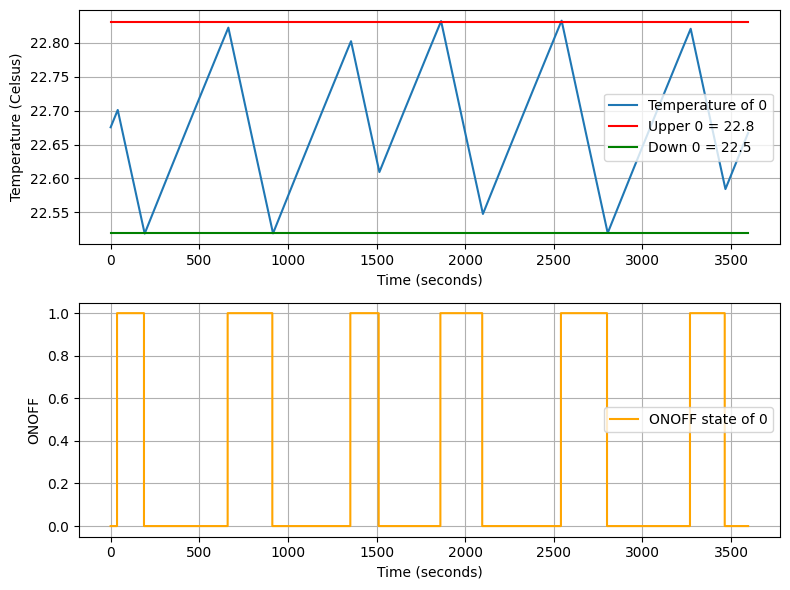

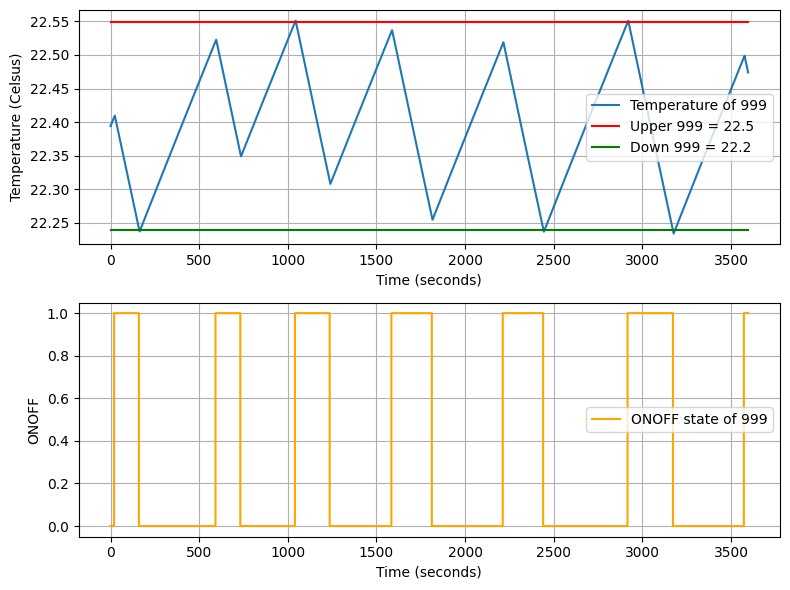

(None, None)

In [18]:
TCL_plot(0),TCL_plot(999)

## 2.虚拟储能的充放电功率、荷电状态

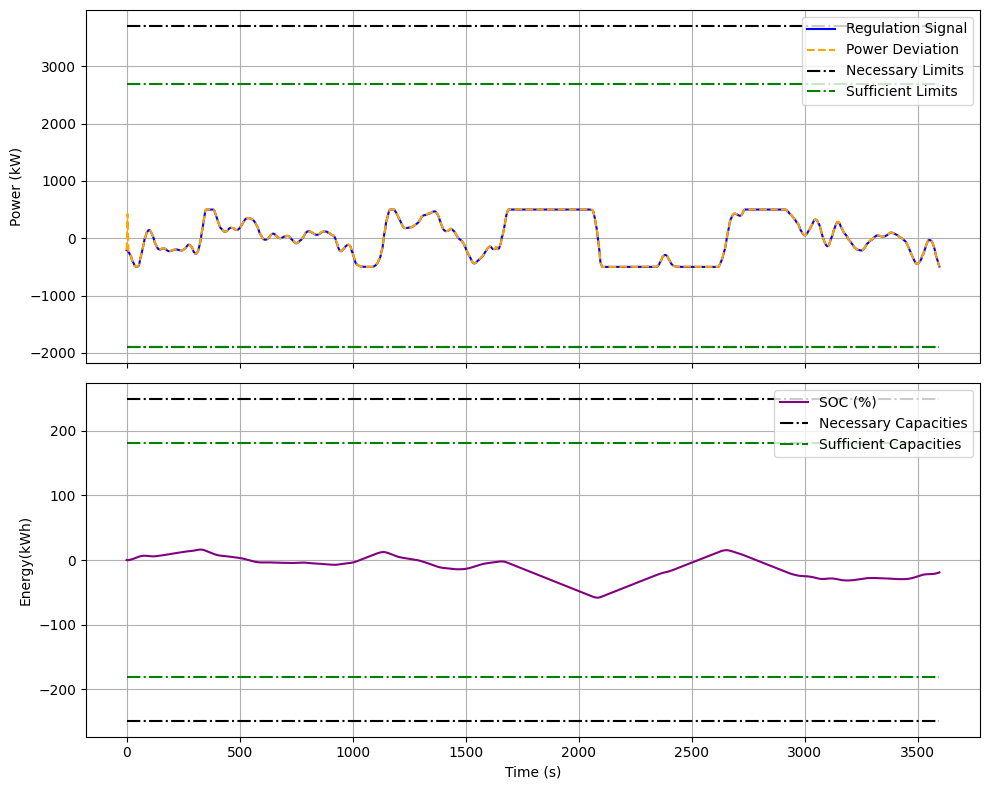

In [19]:
plot_power_and_soc(ts, h, AGC, Ps, Bn, Bs, t_span, initial_soc=0.5)

## 3.空调集群的消耗的实际功率

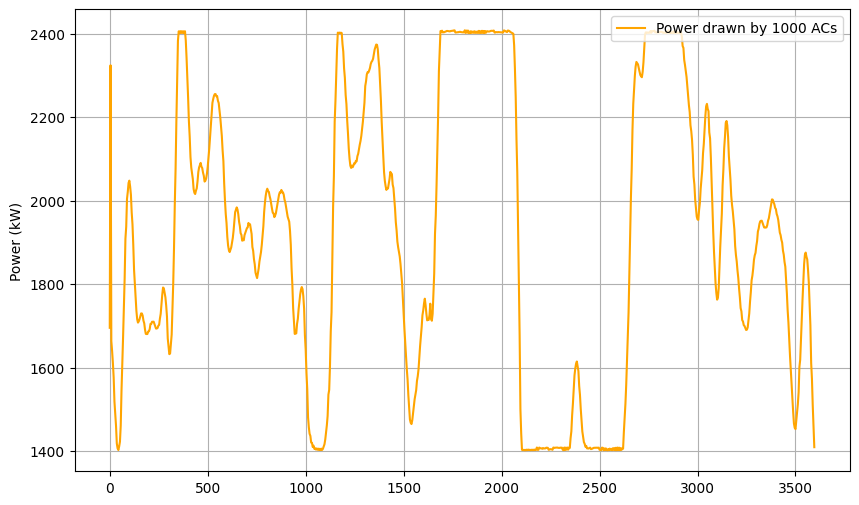

In [20]:
plot_TCLs_power(ts, h, AGC, Ps, t_span, sum(para[PoIDX]))

# DEBUG

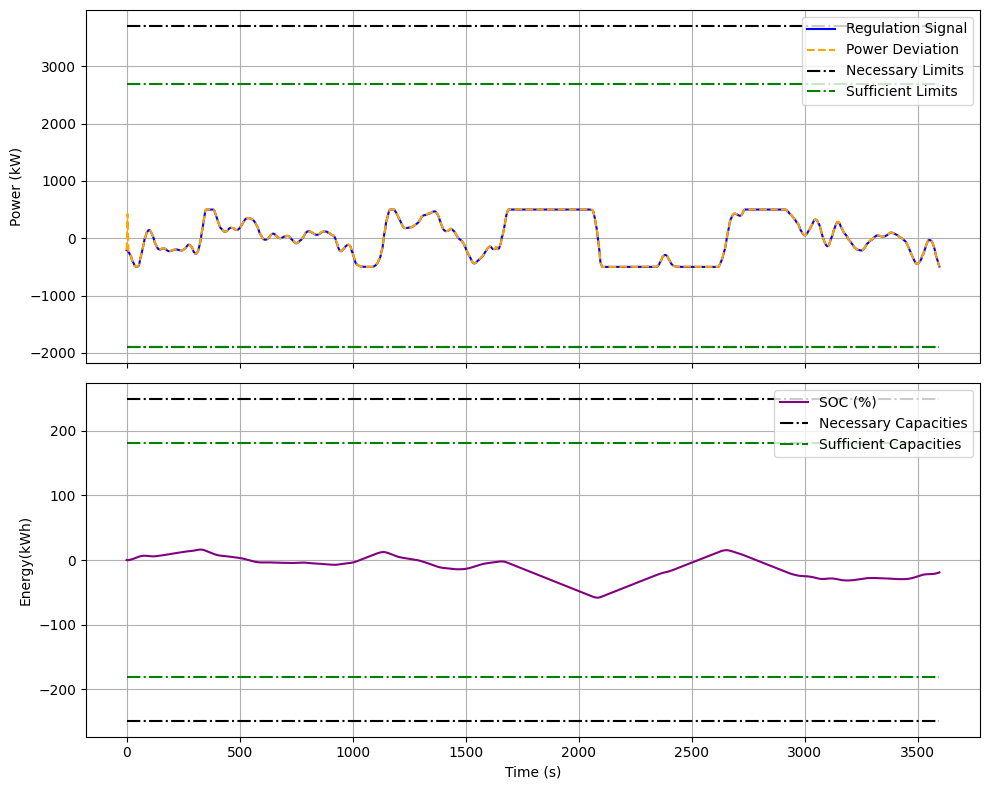

500

In [21]:
plot_power_and_soc(ts, h, AGC, Ps, Bn, Bs, t_span, initial_soc=0.5)
Amplifier

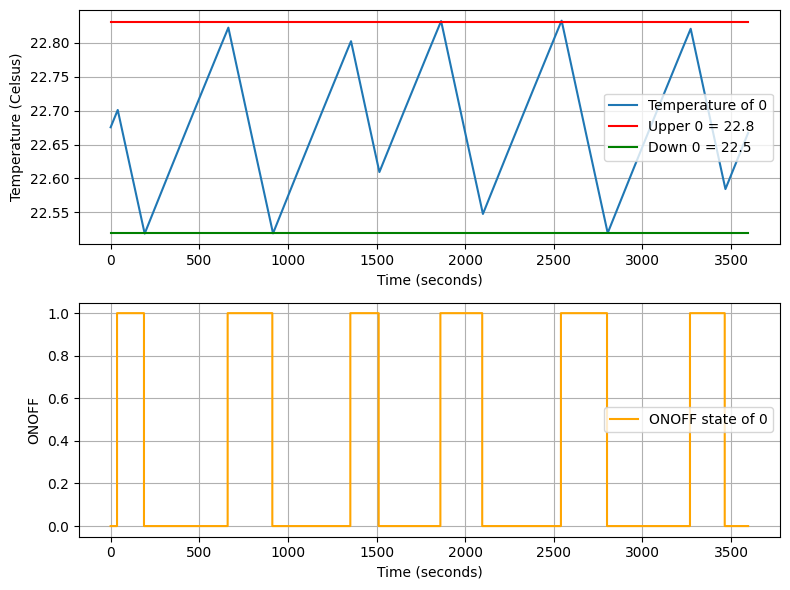

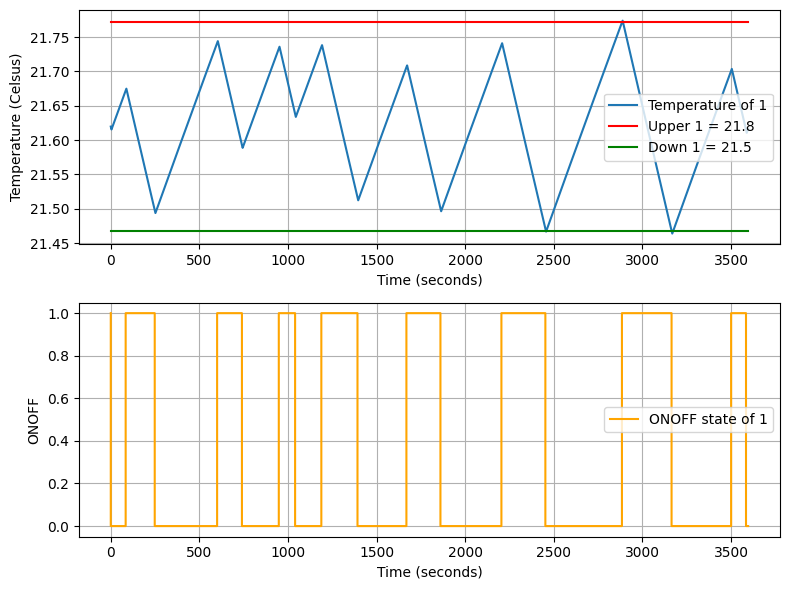

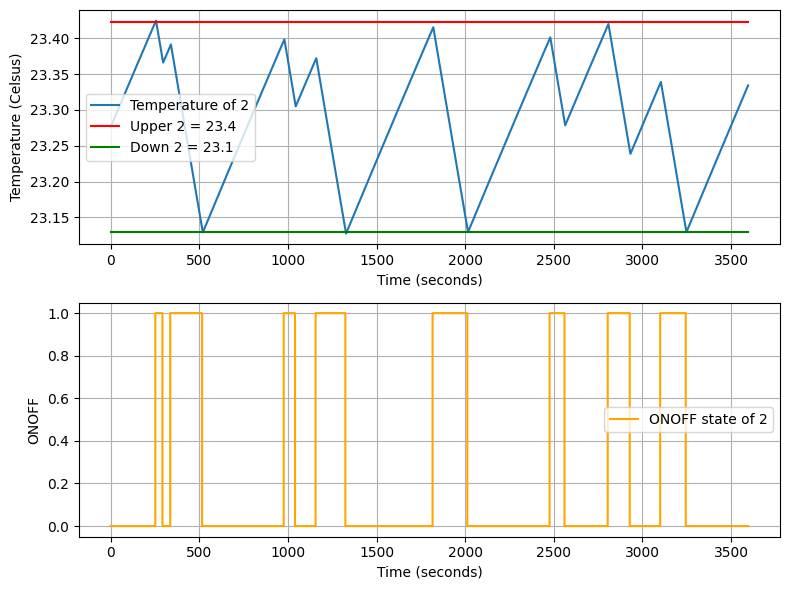

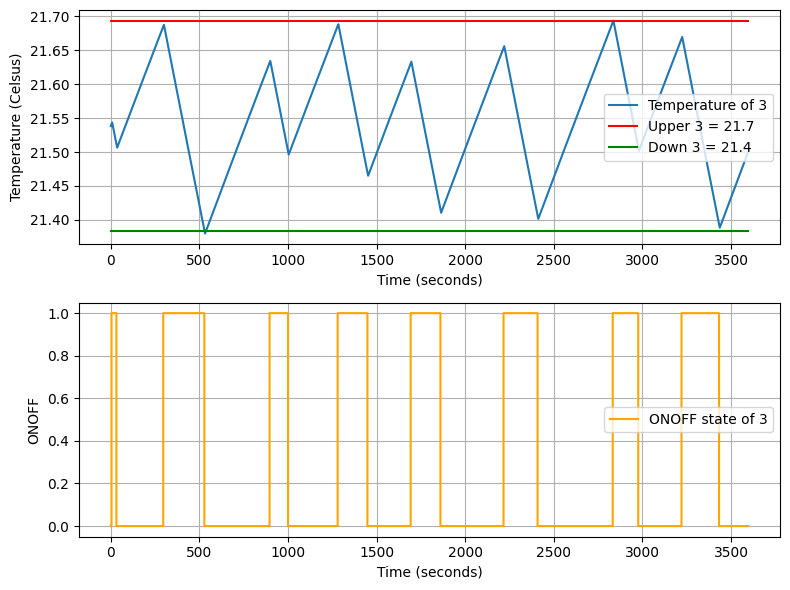

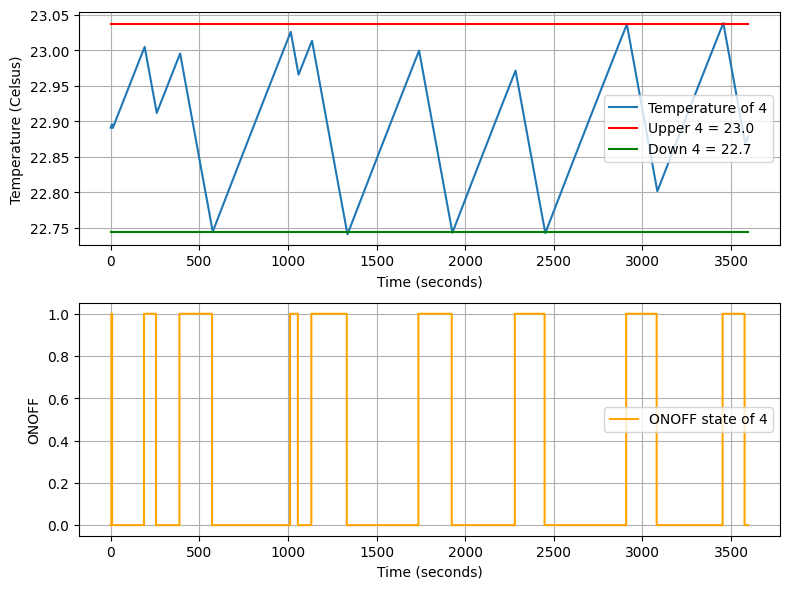

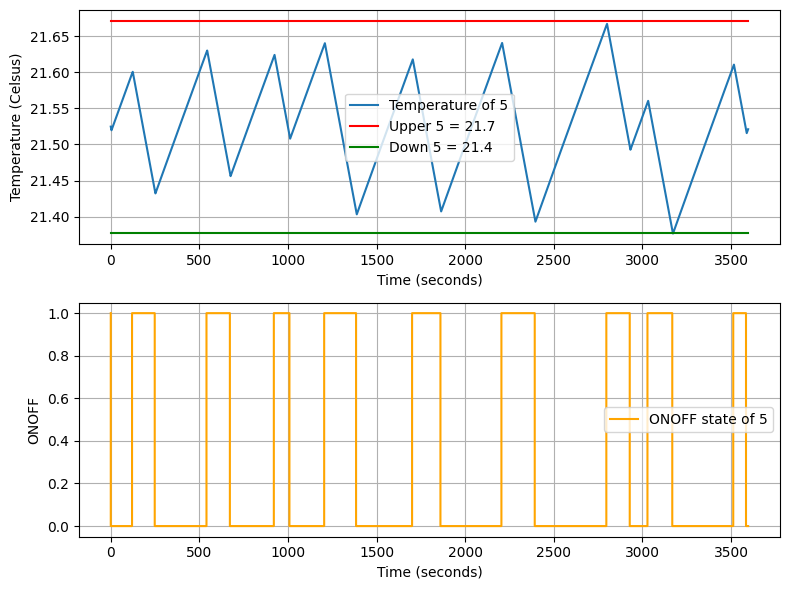

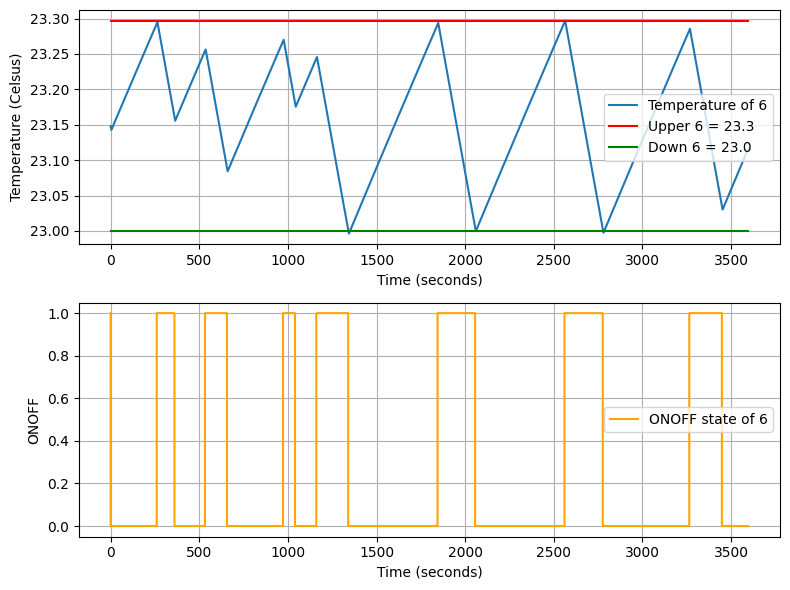

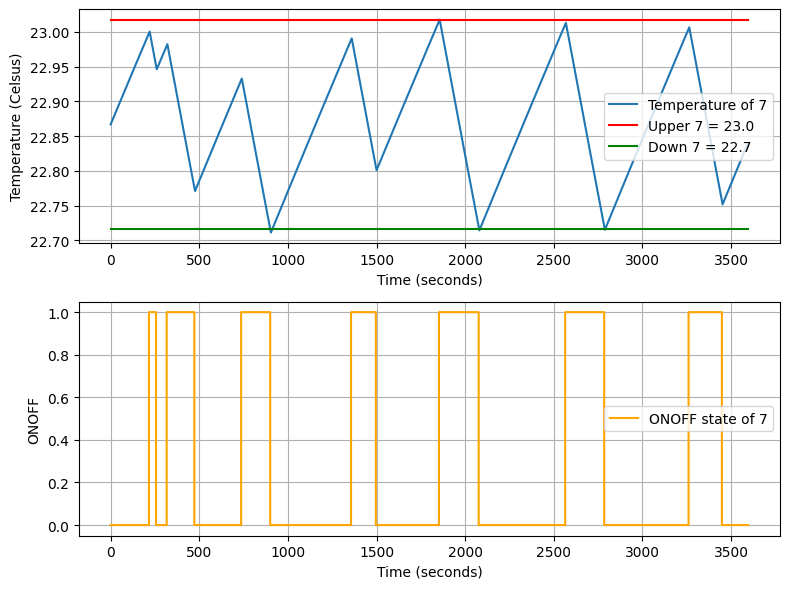

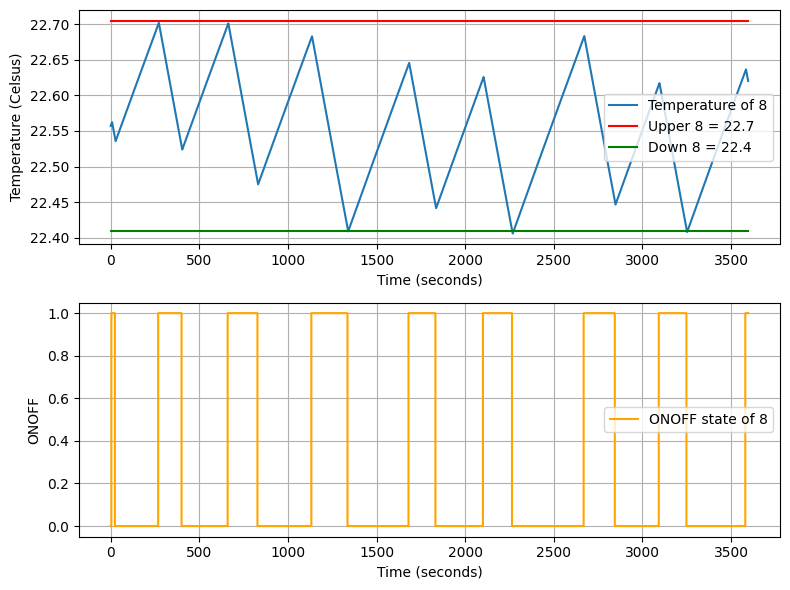

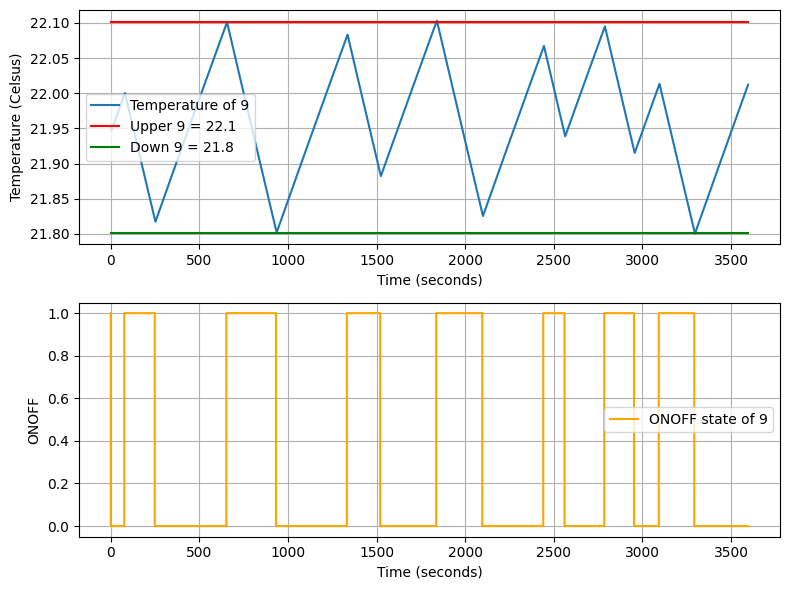

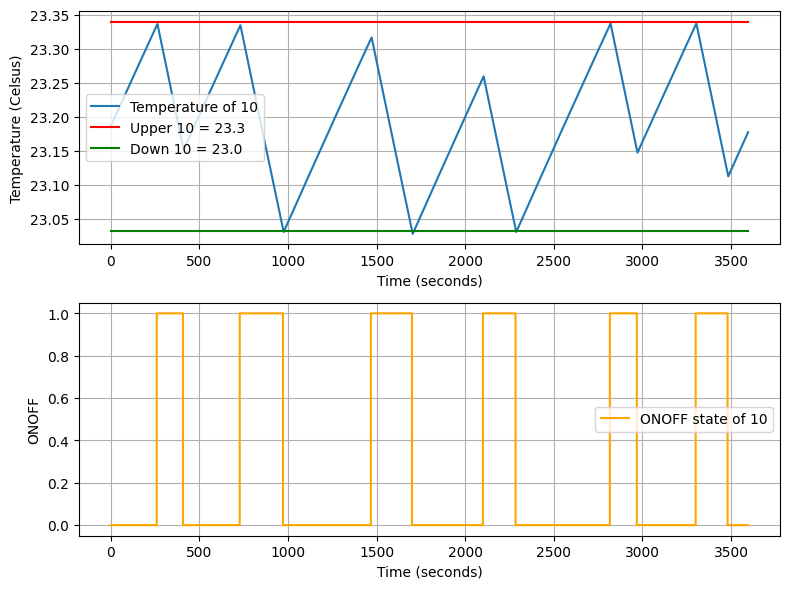

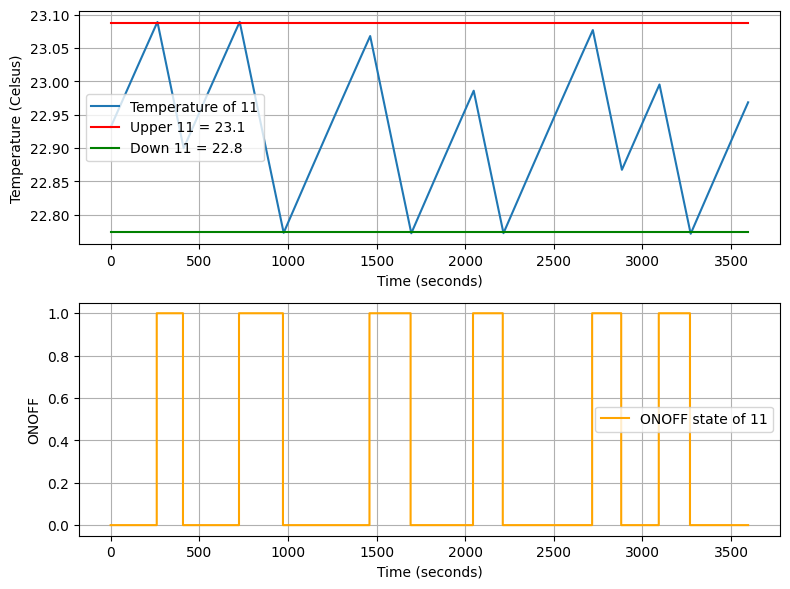

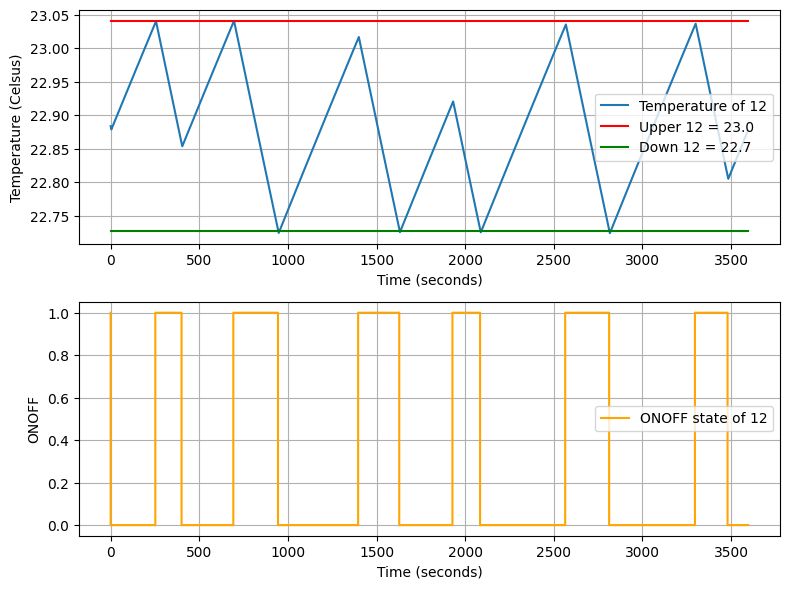

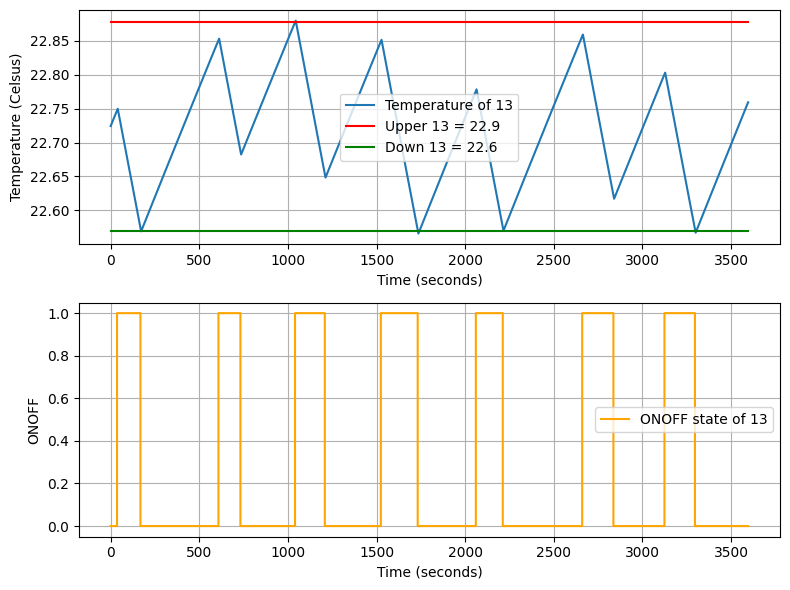

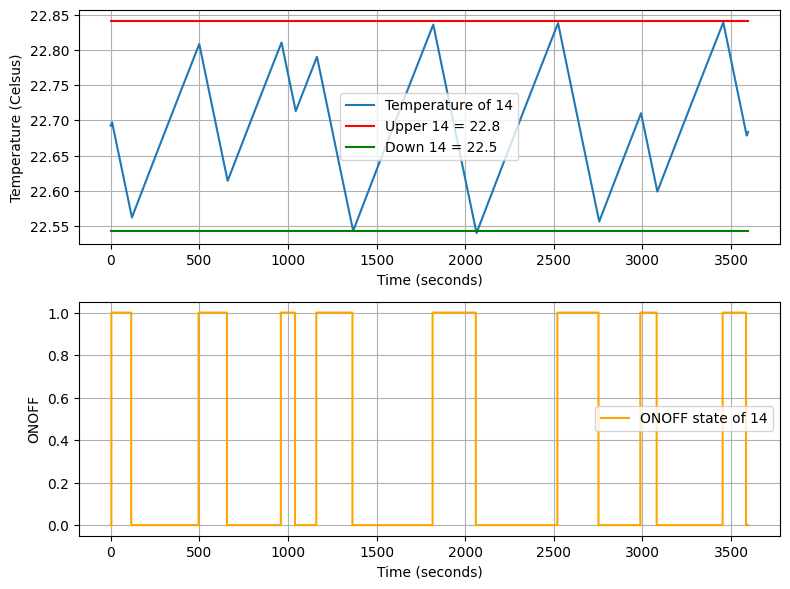

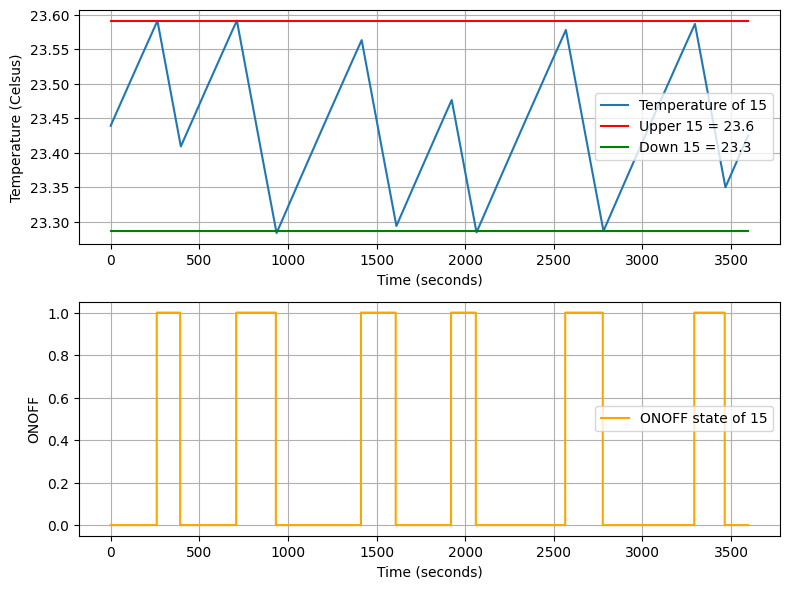

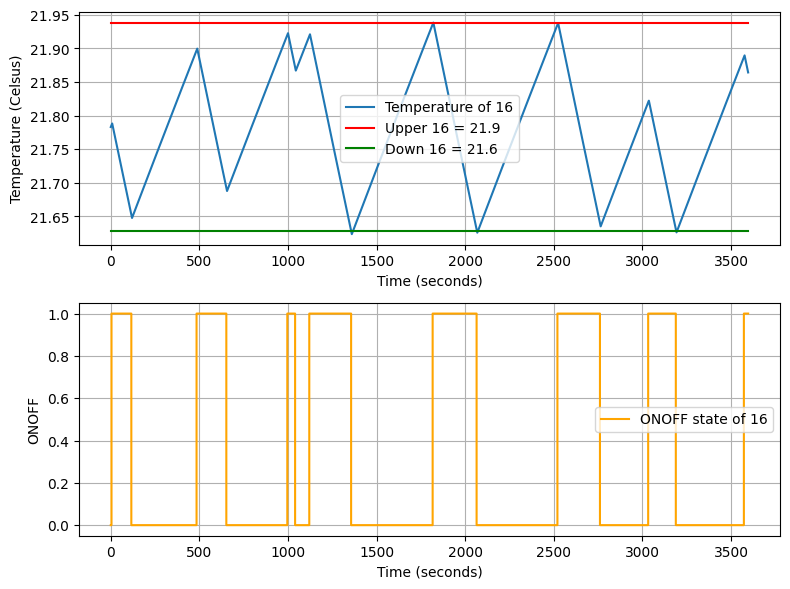

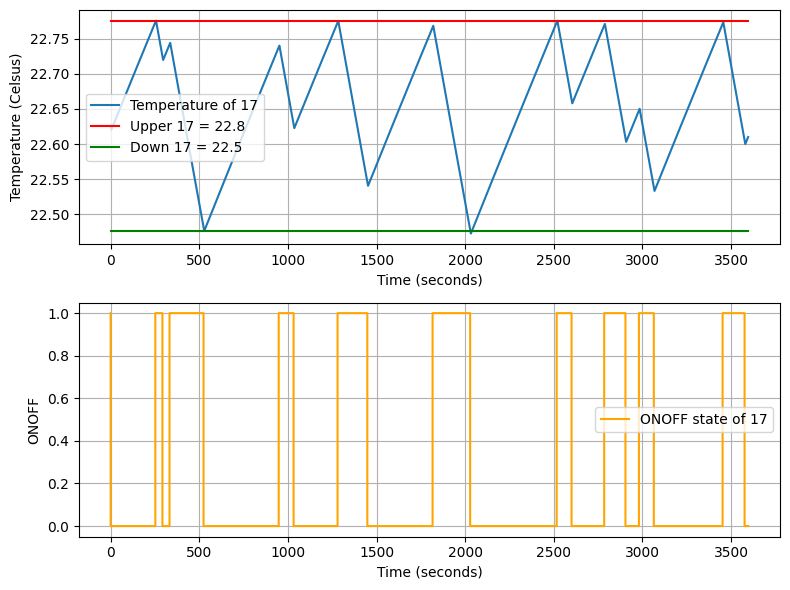

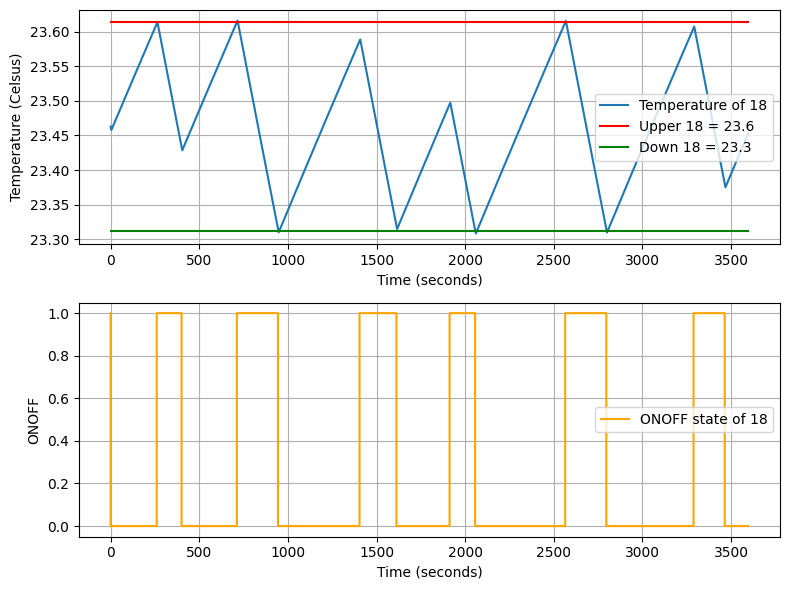

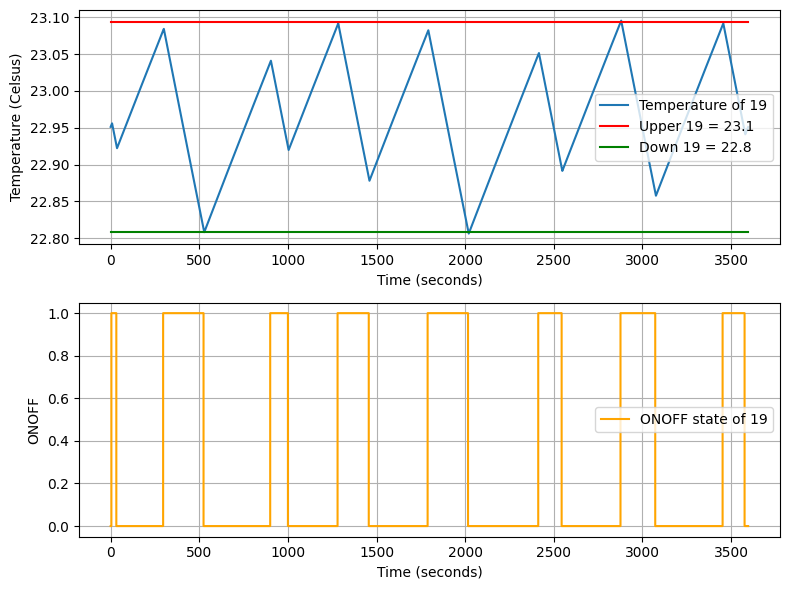

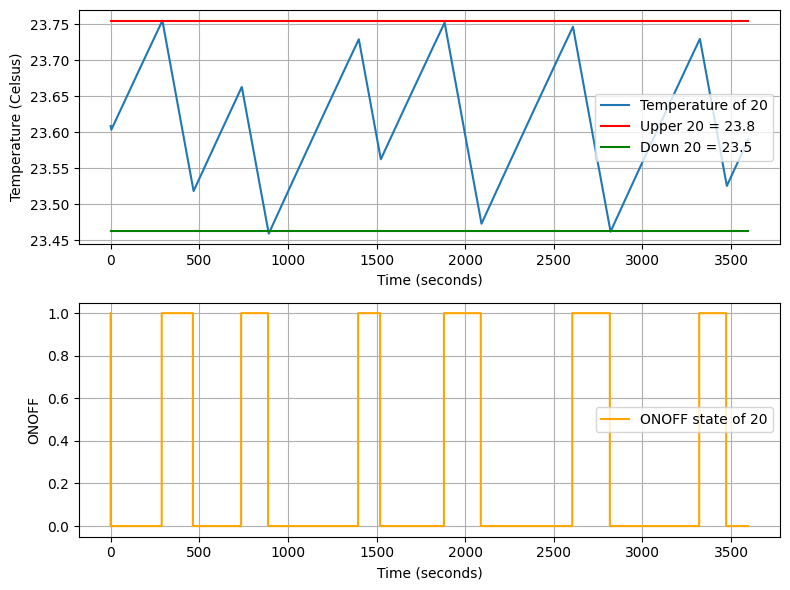

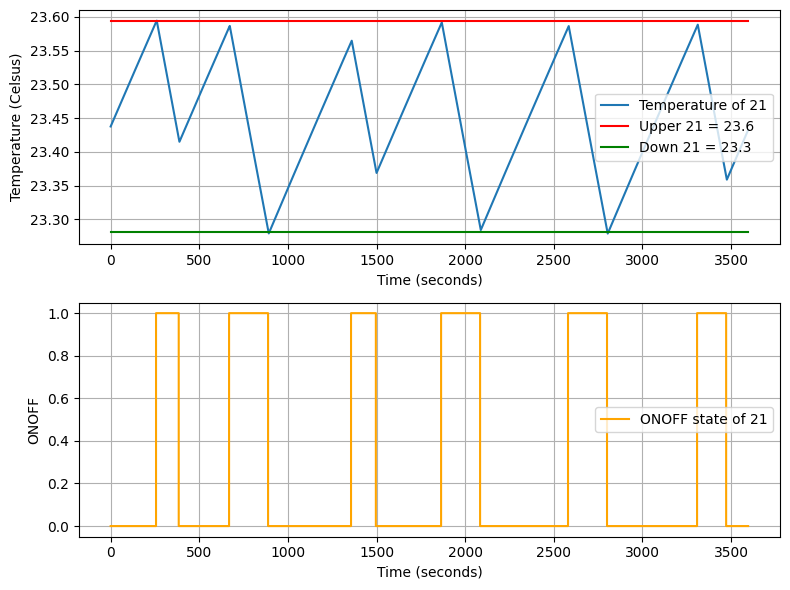

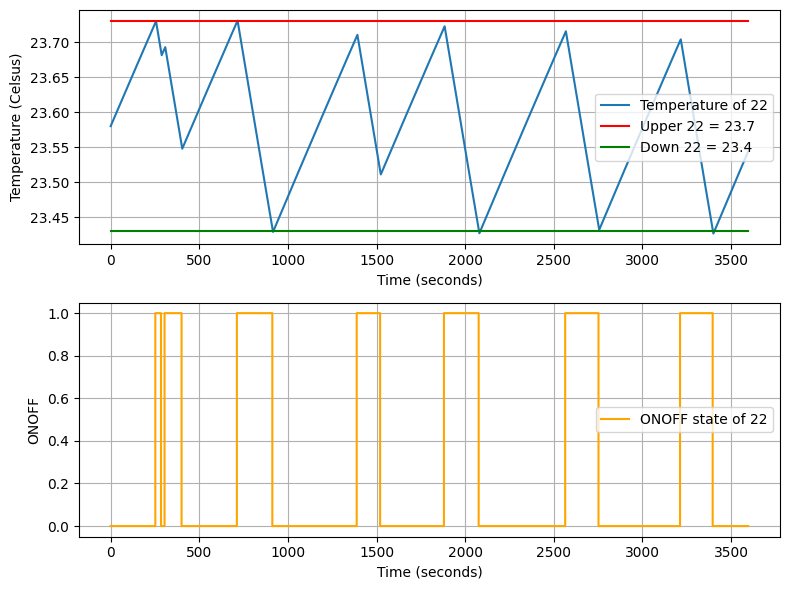

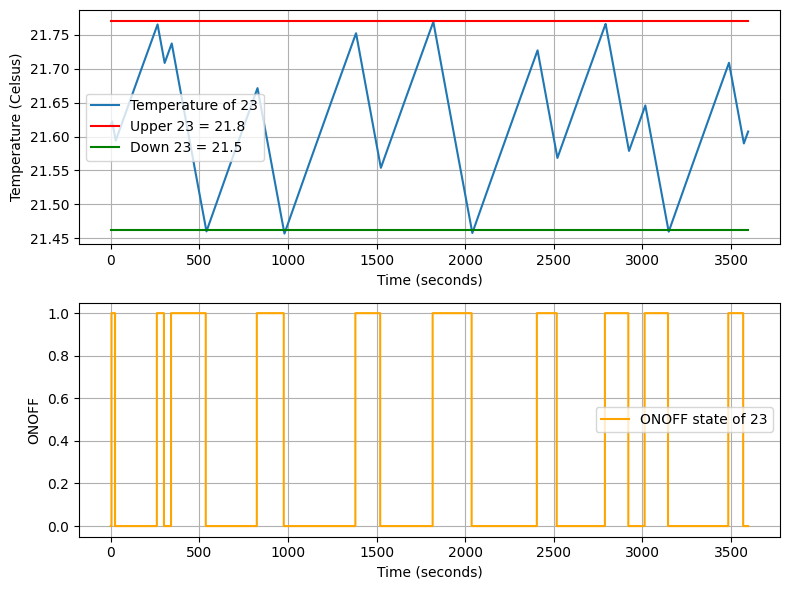

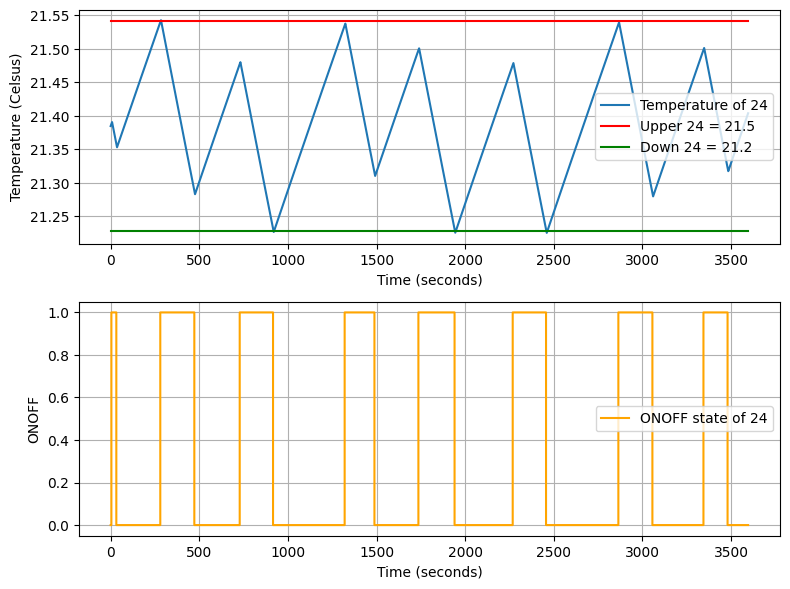

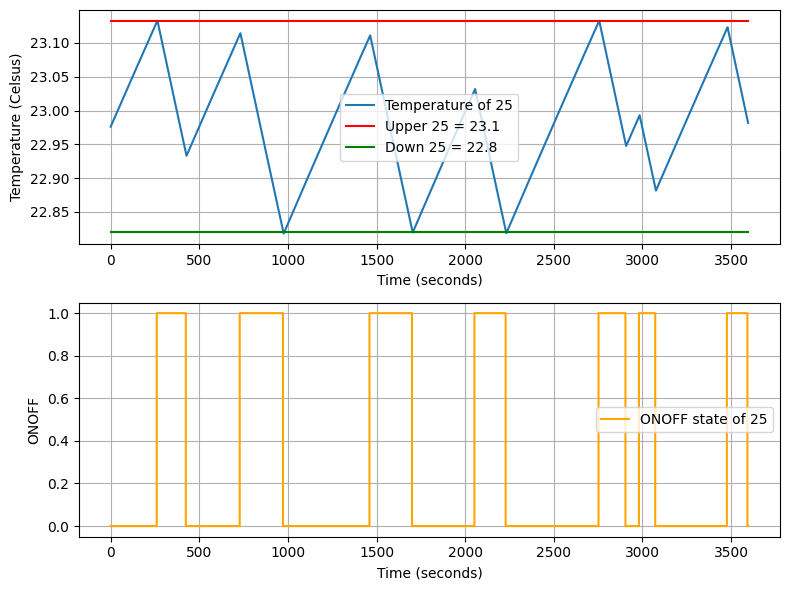

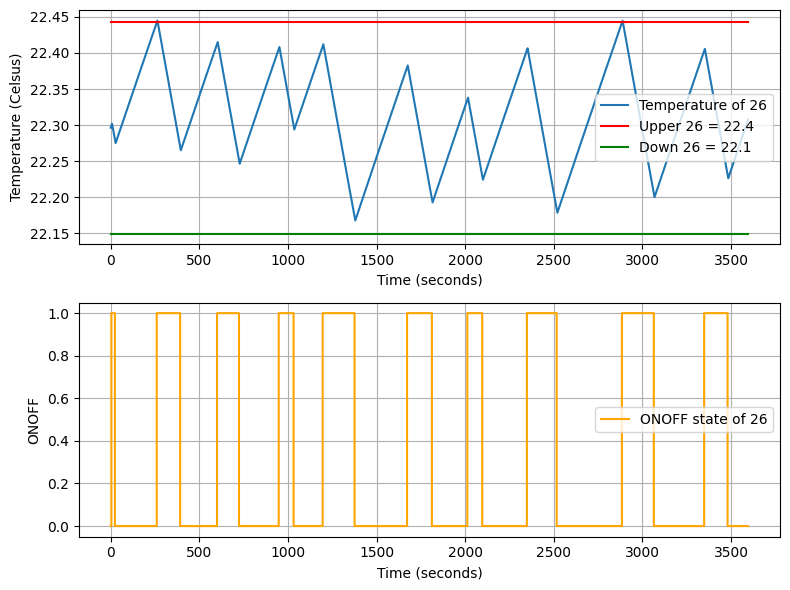

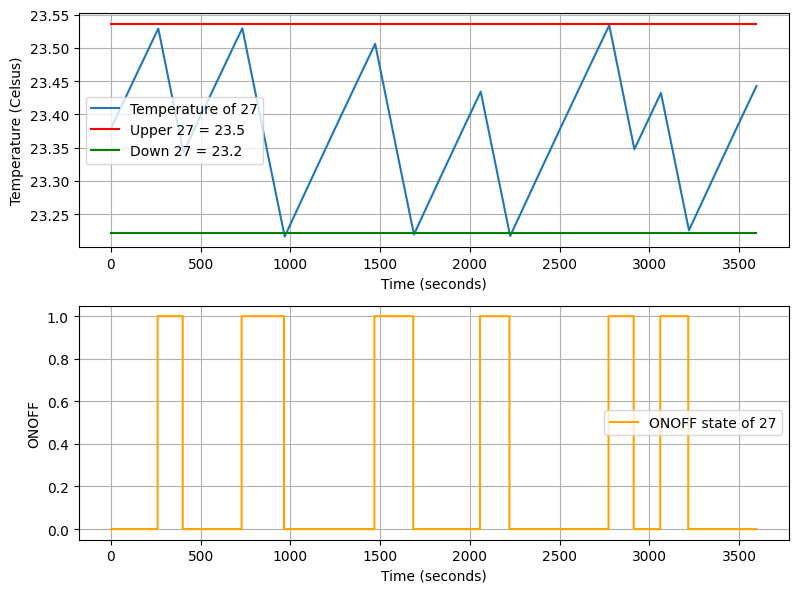

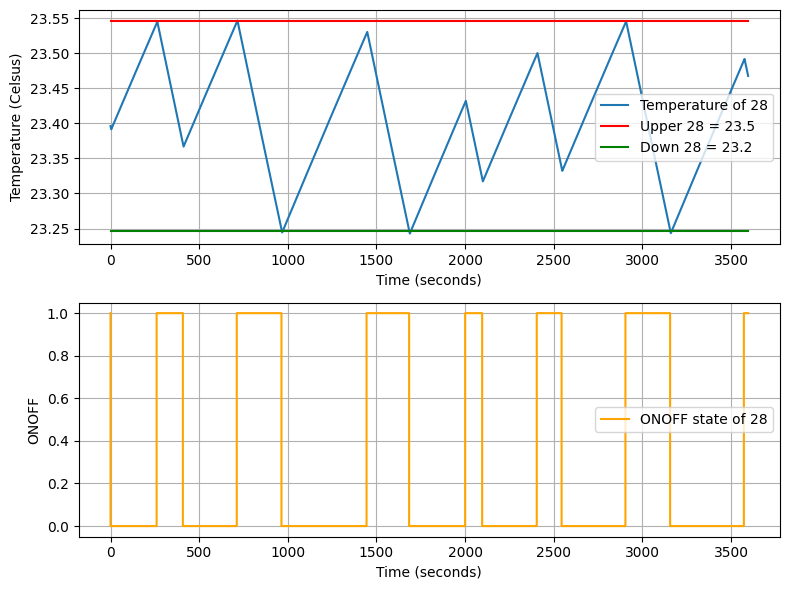

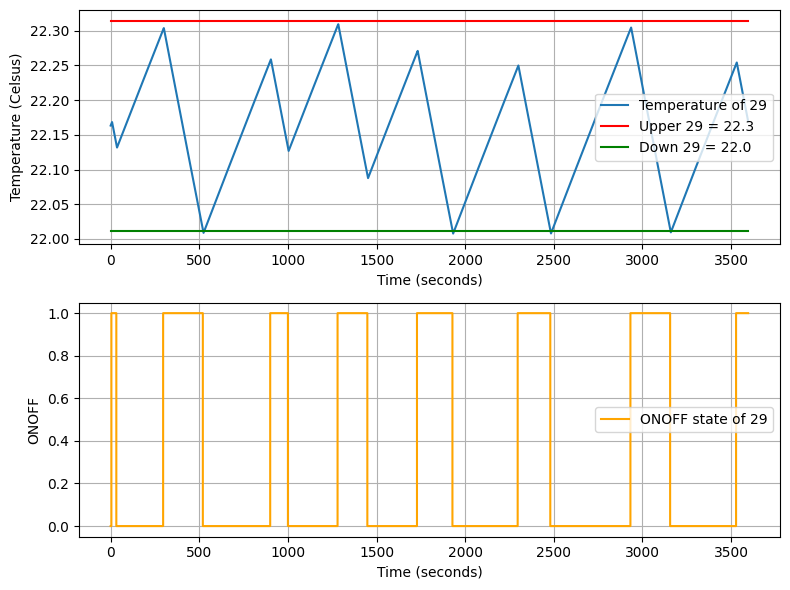

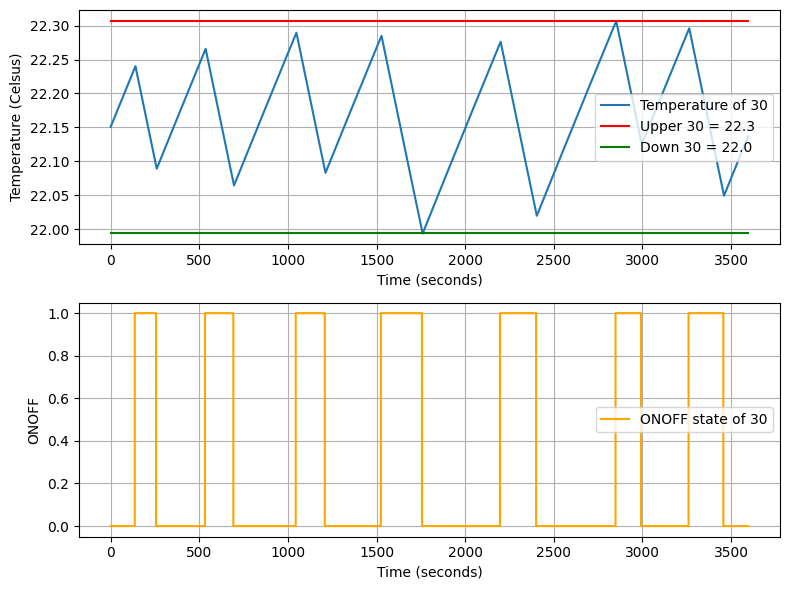

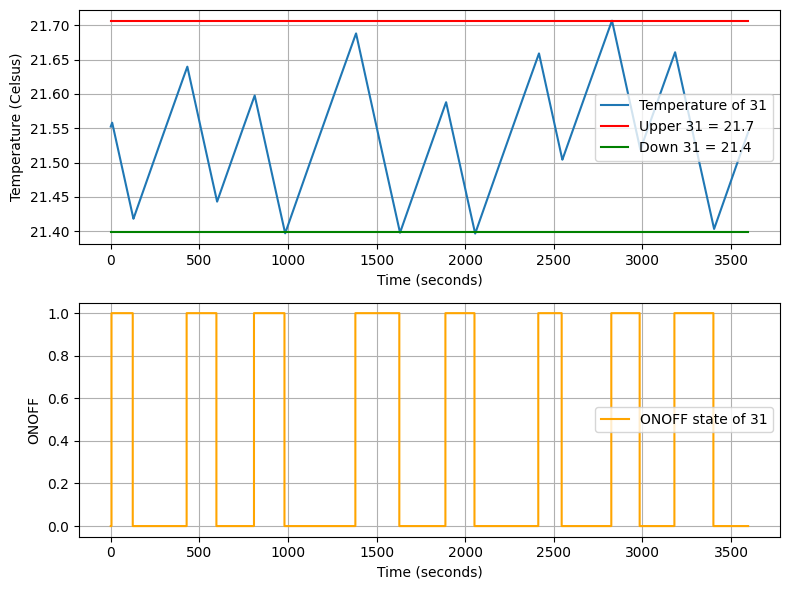

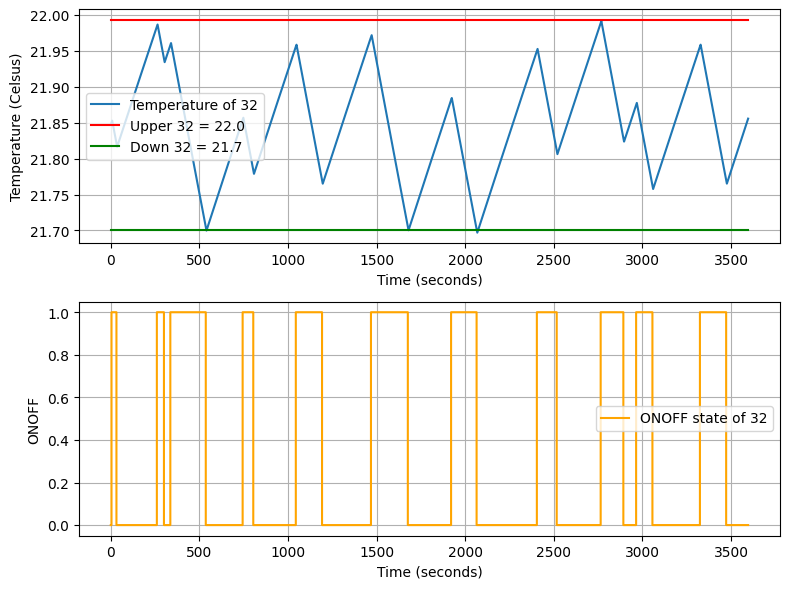

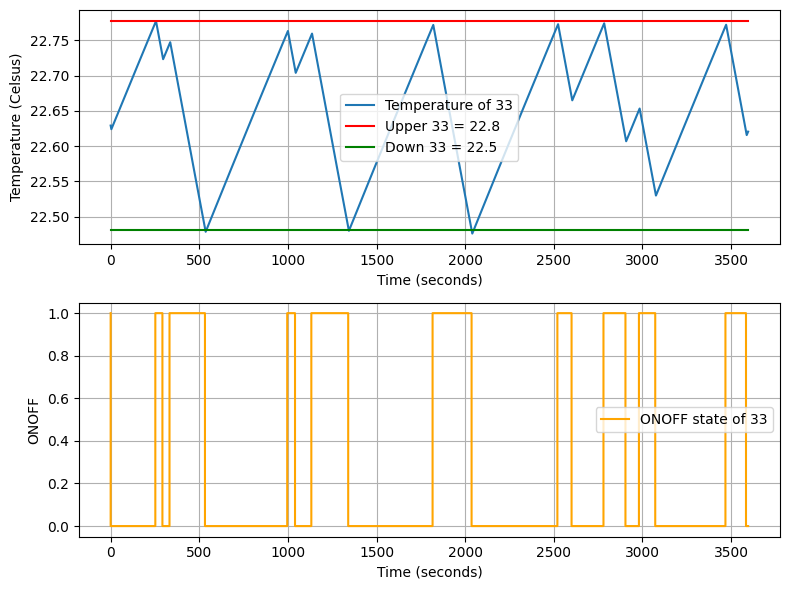

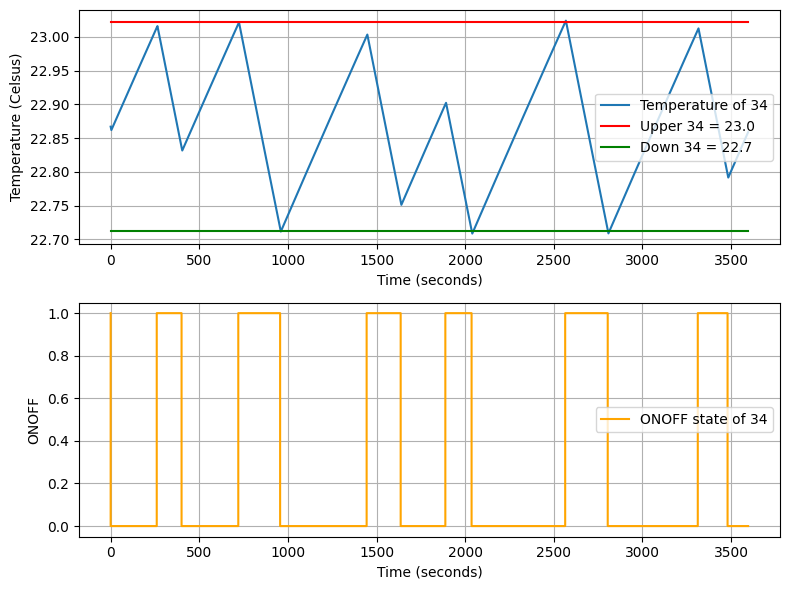

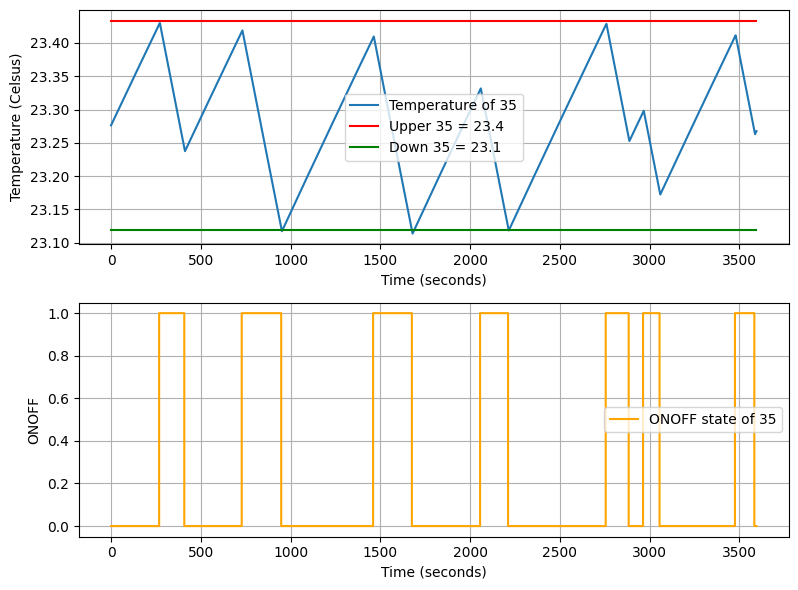

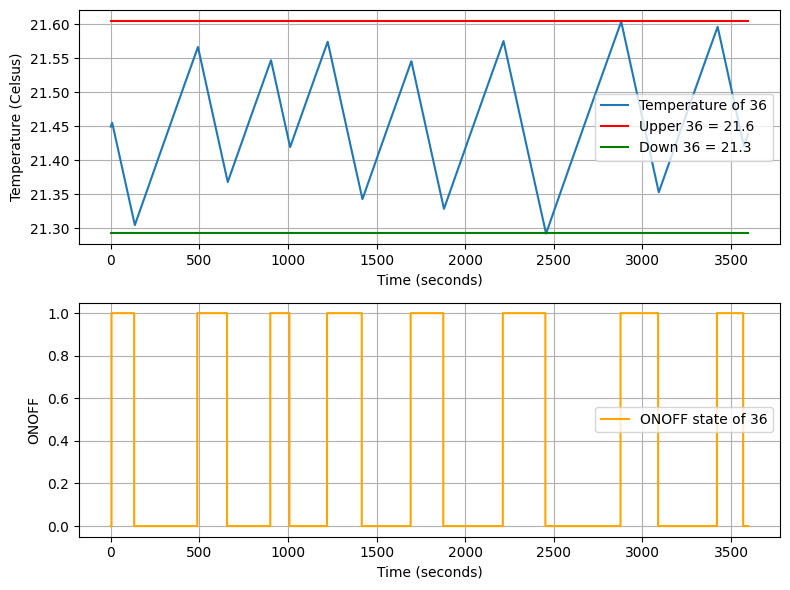

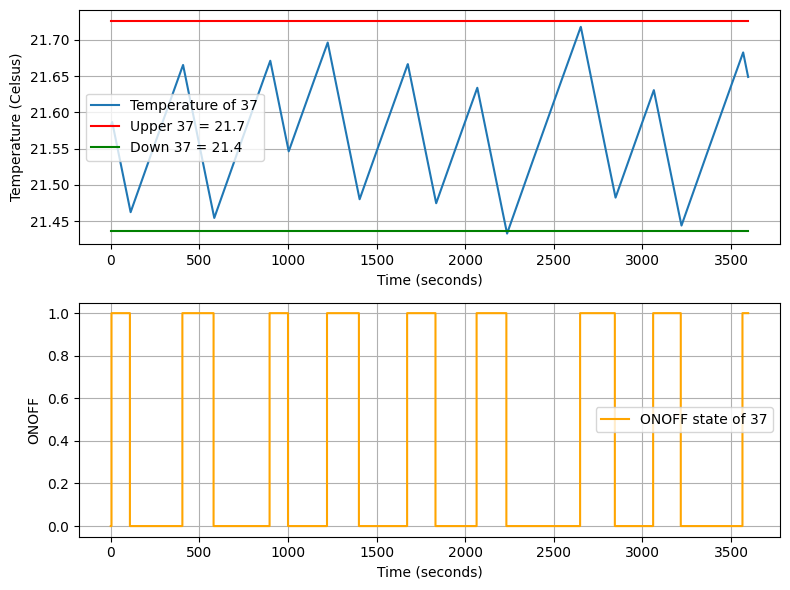

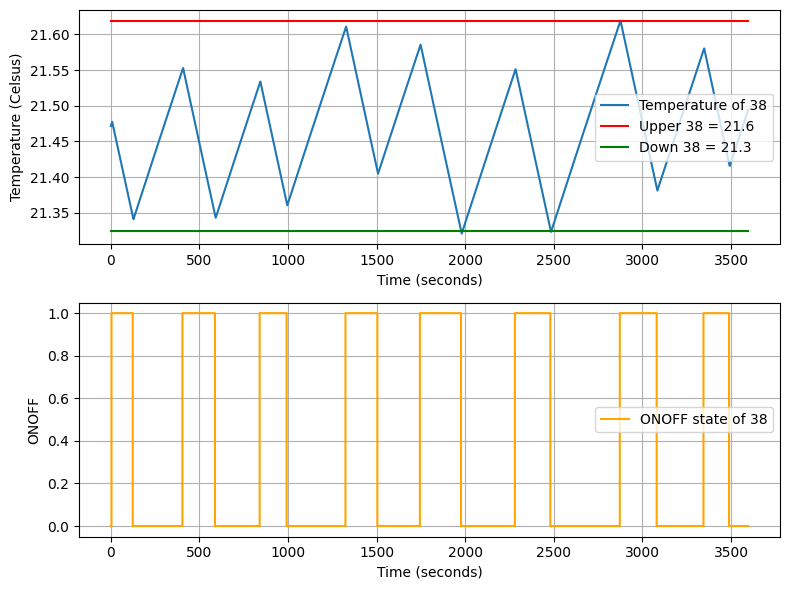

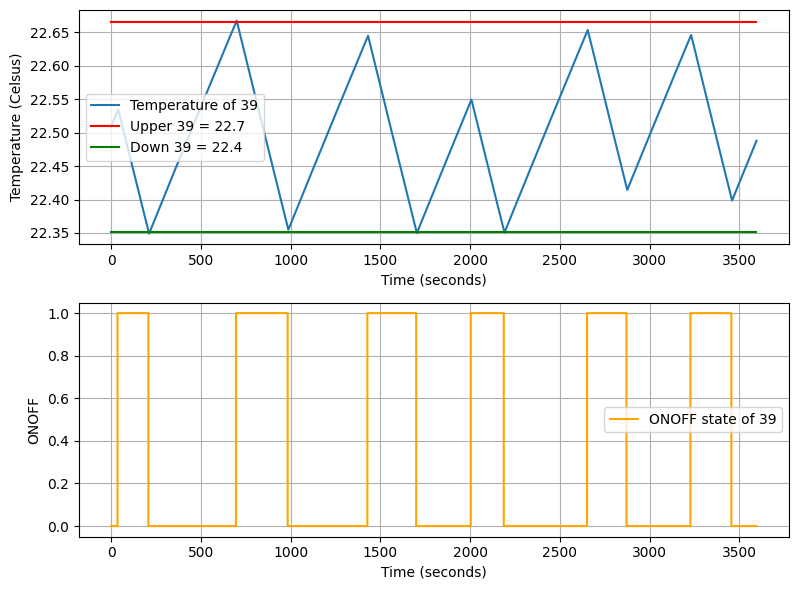

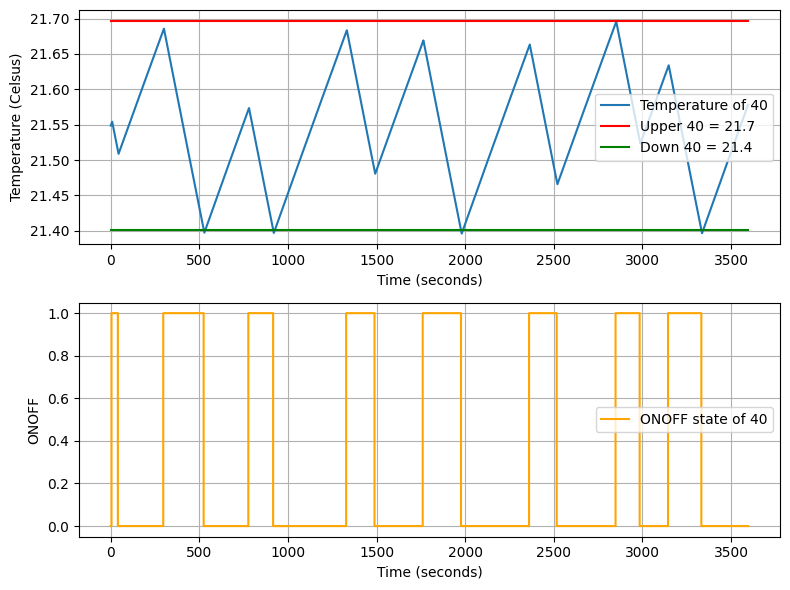

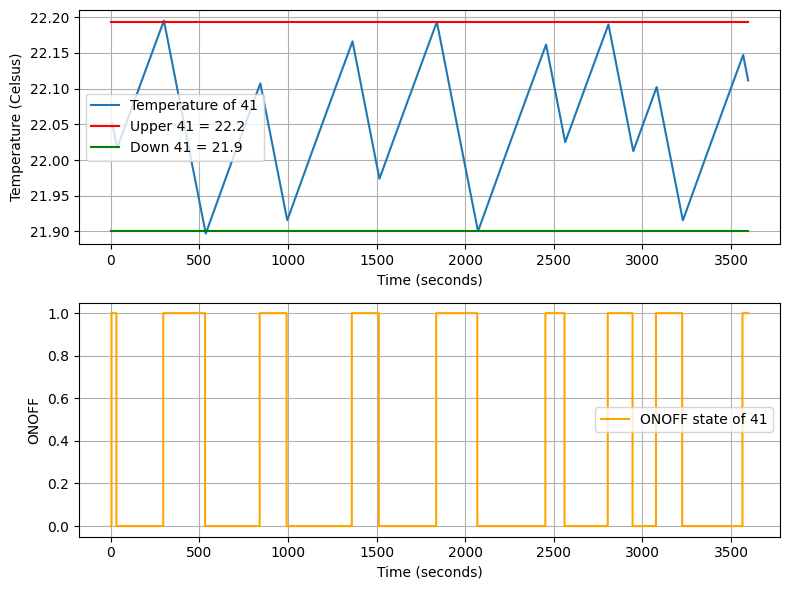

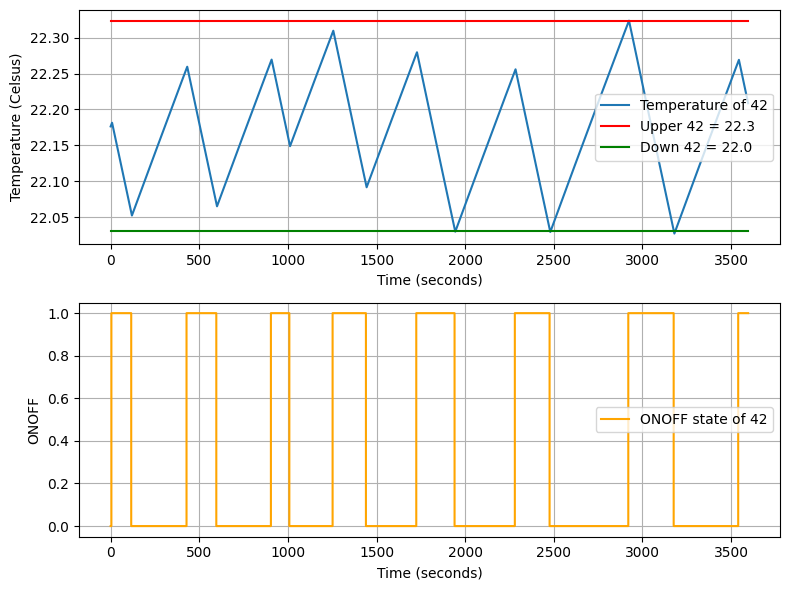

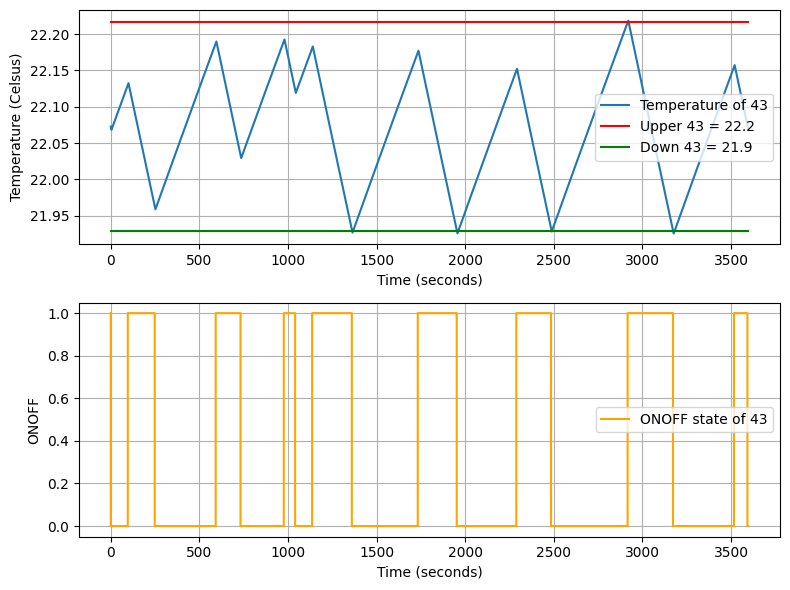

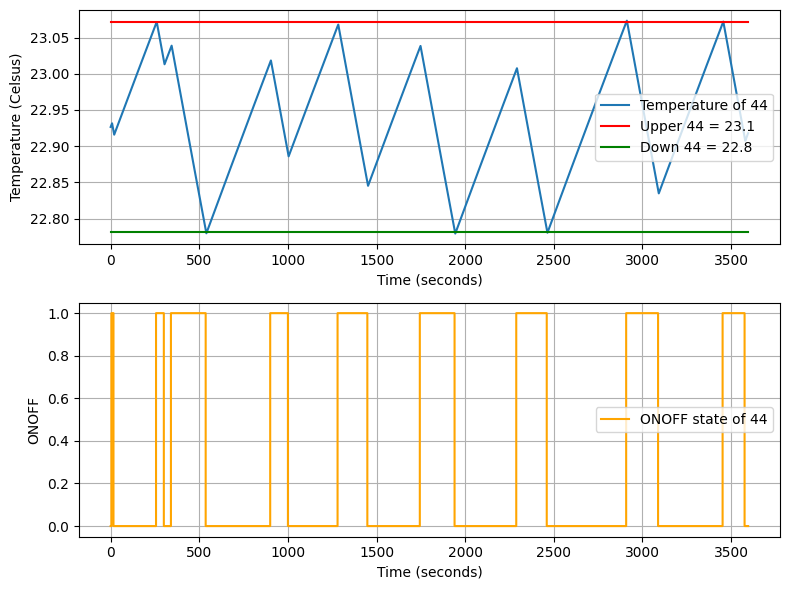

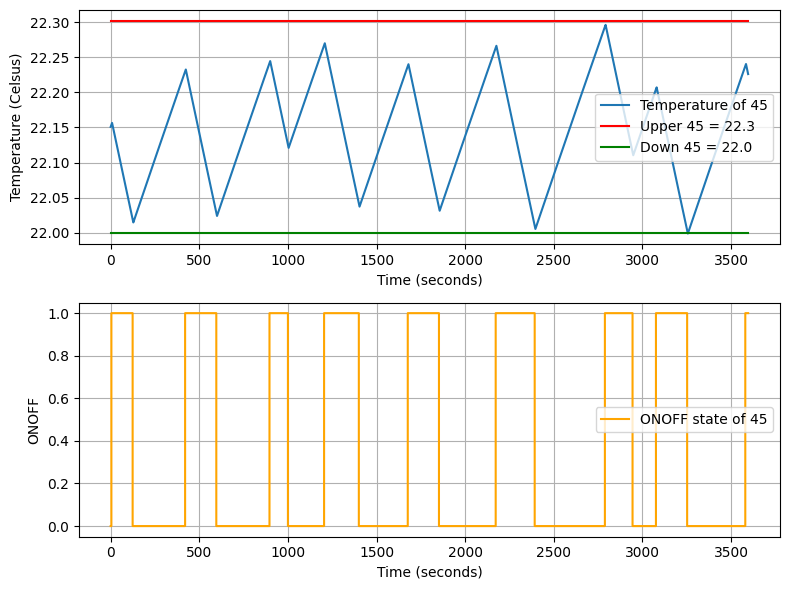

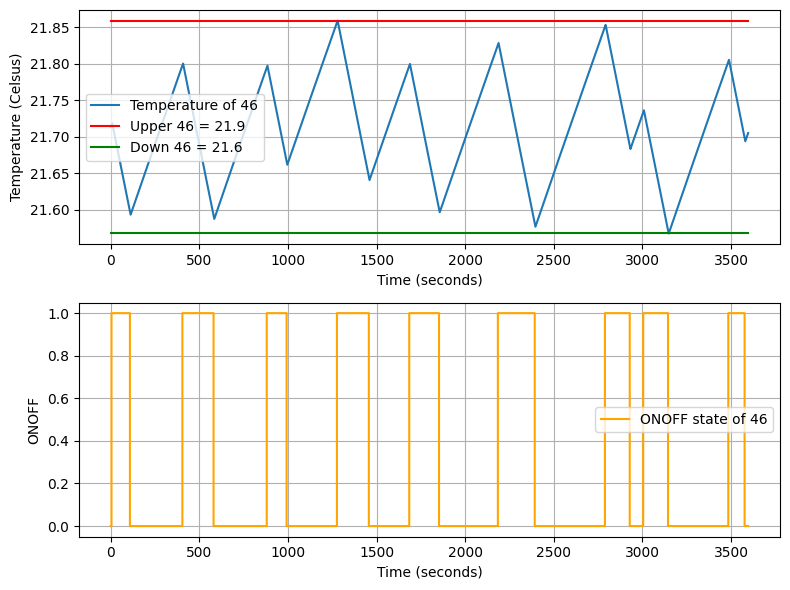

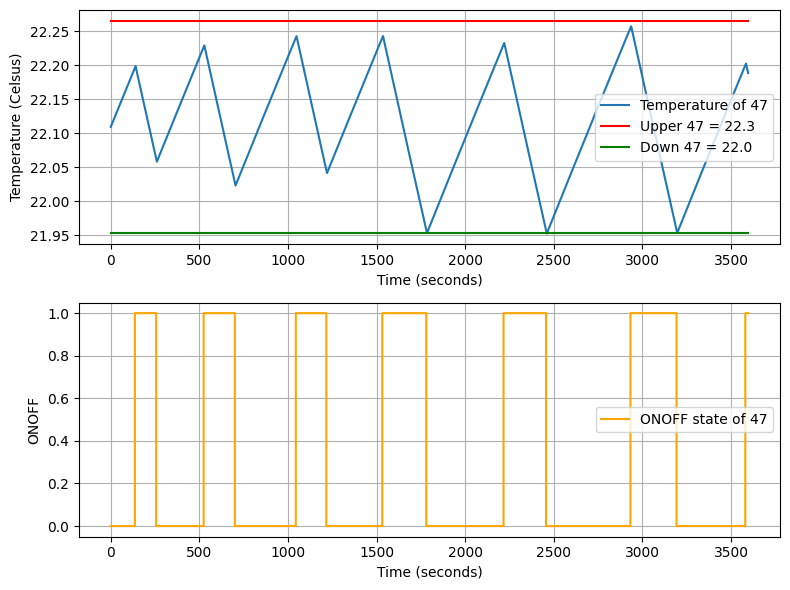

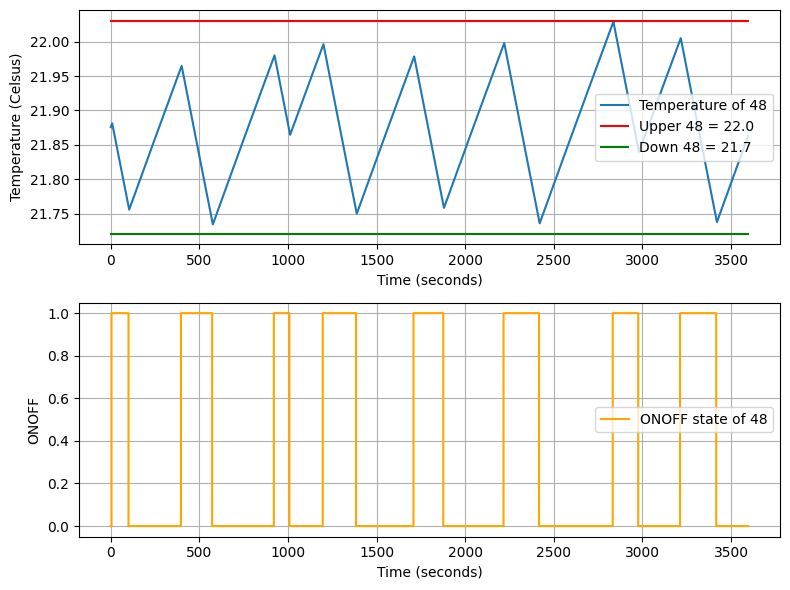

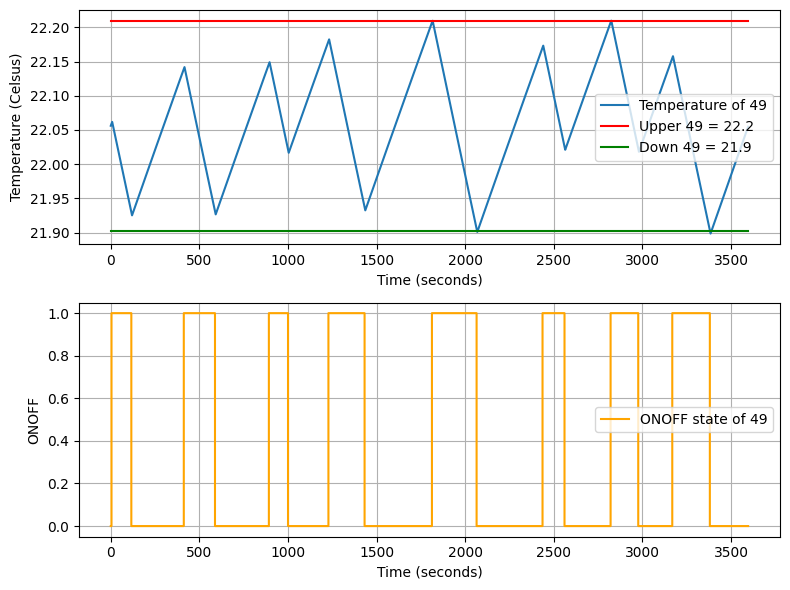

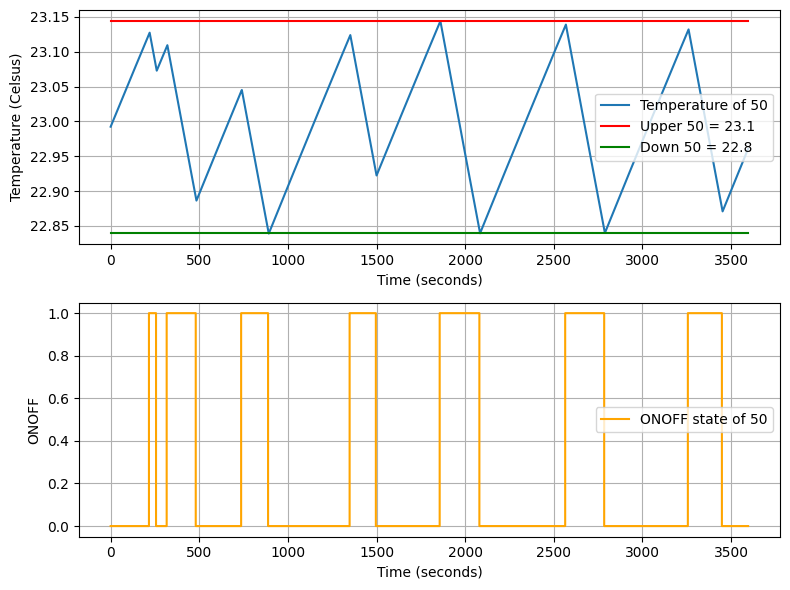

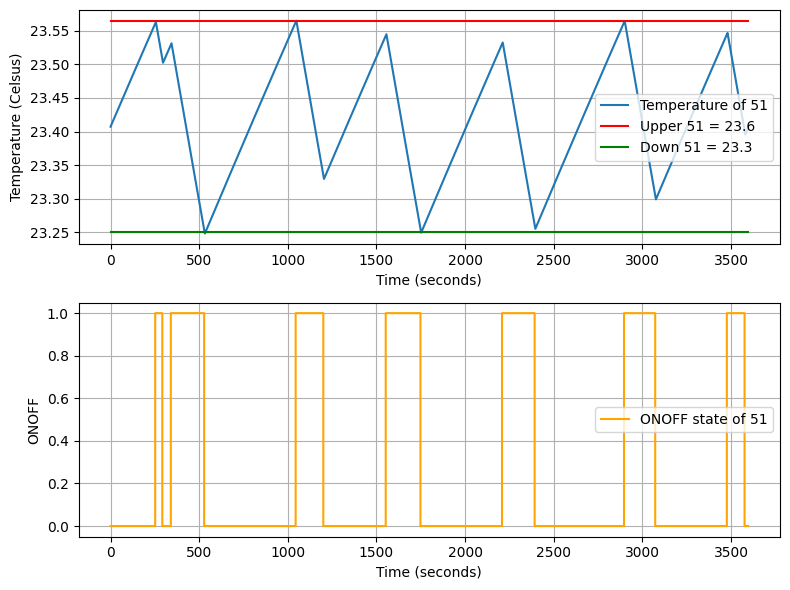

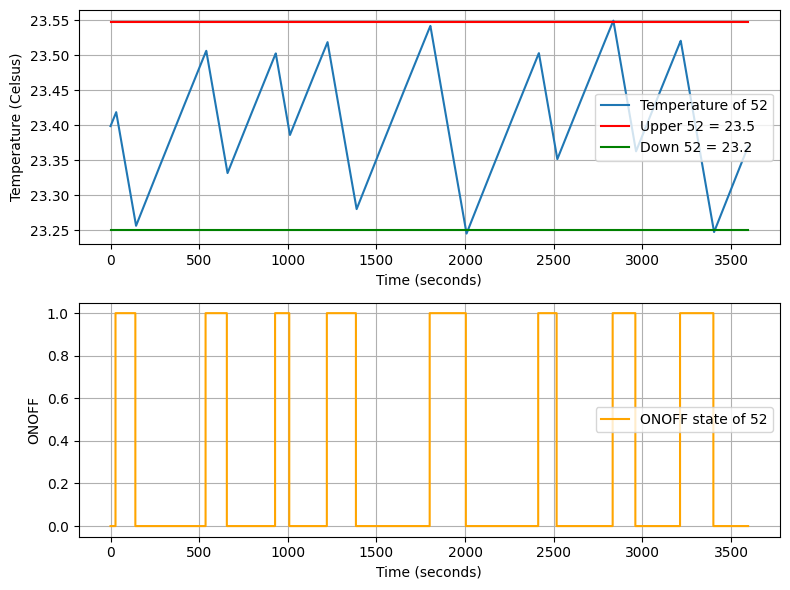

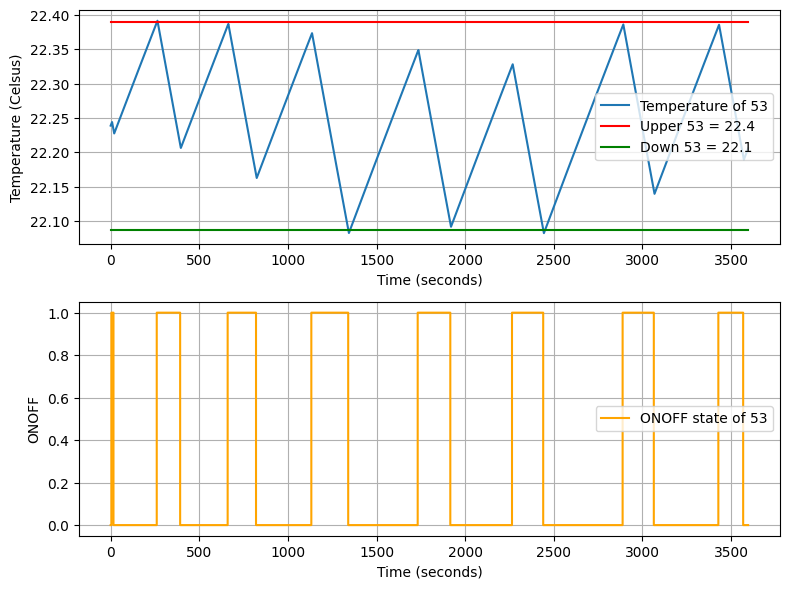

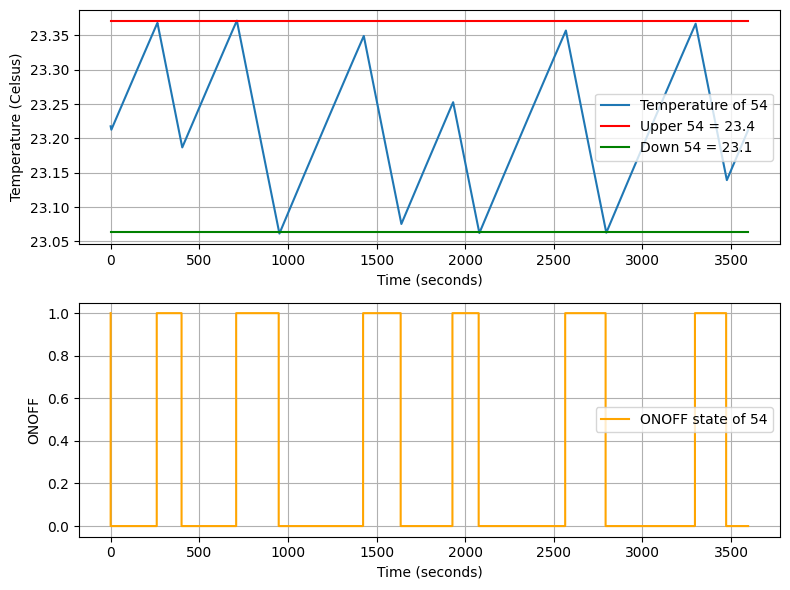

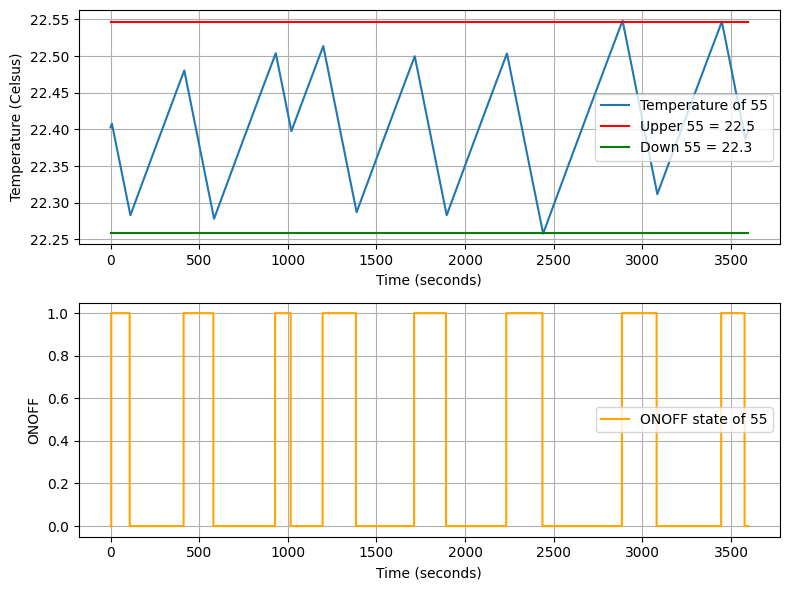

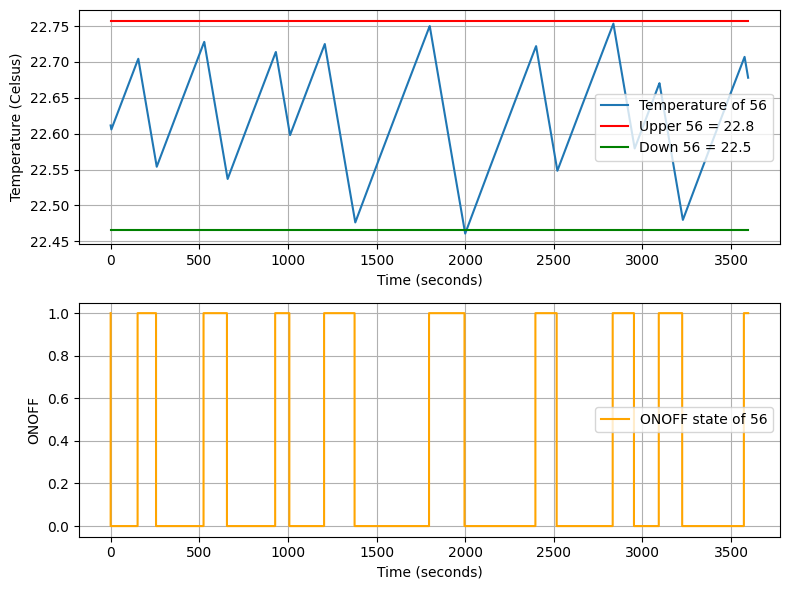

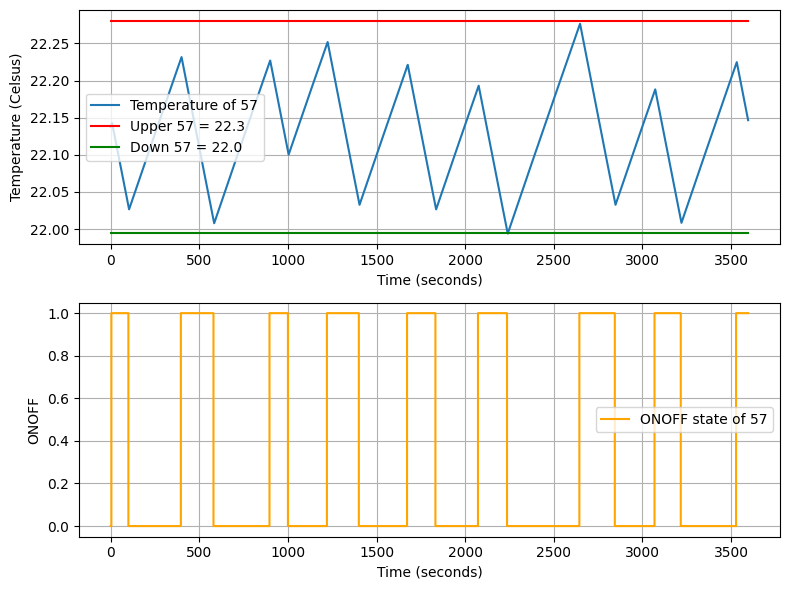

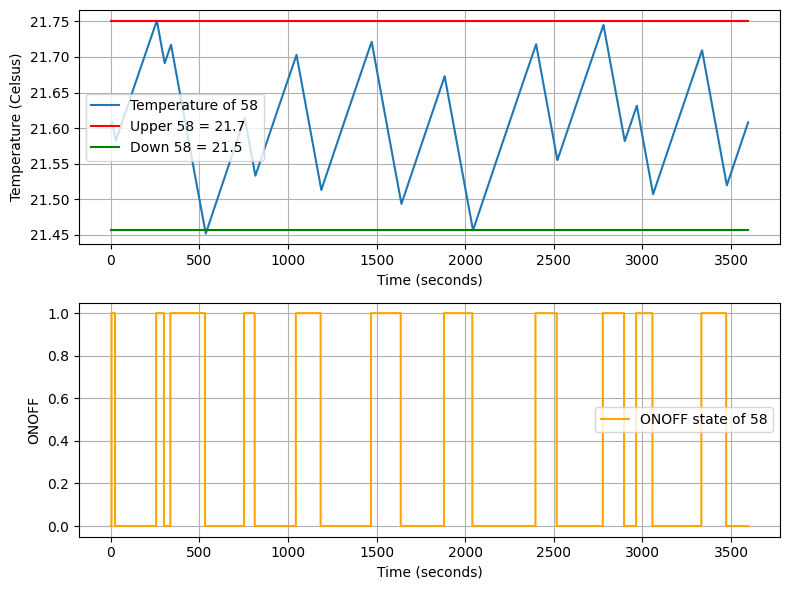

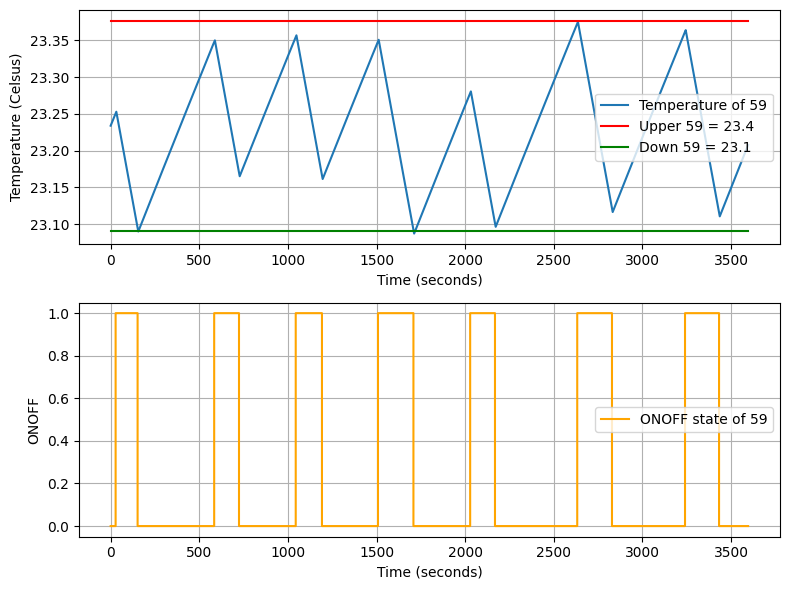

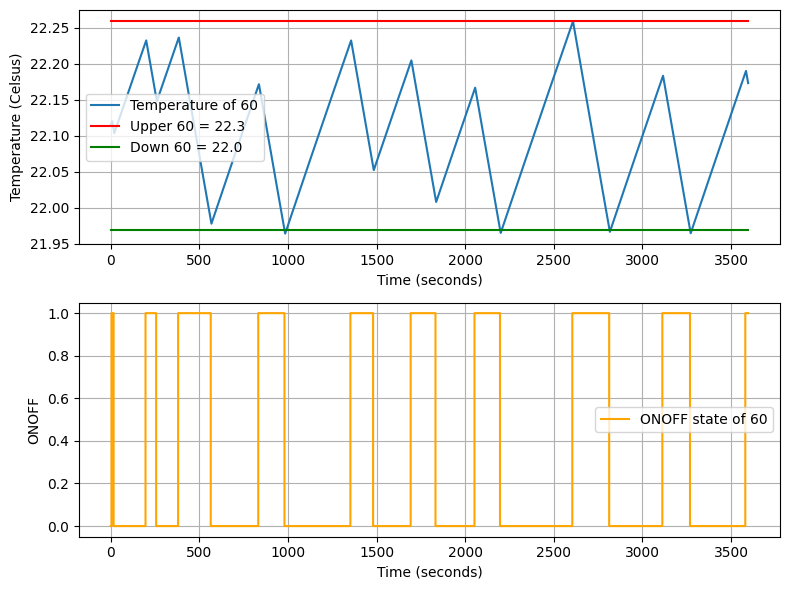

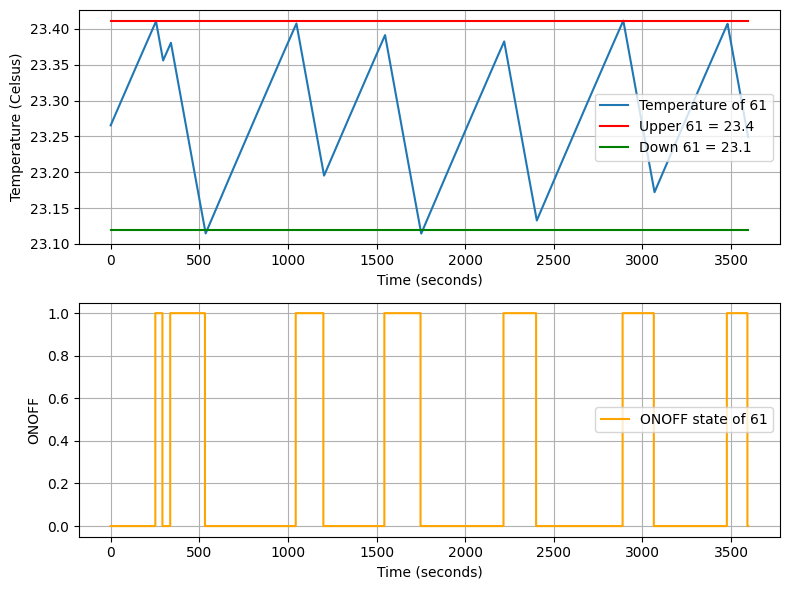

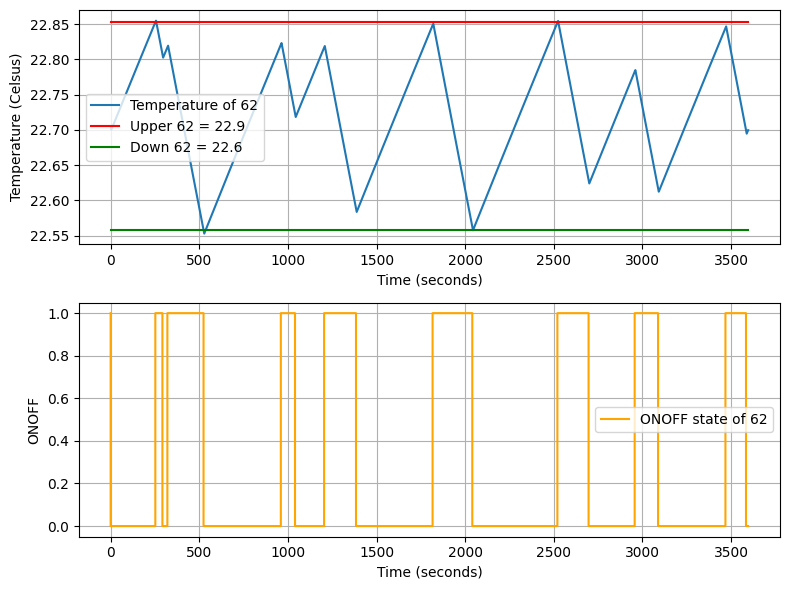

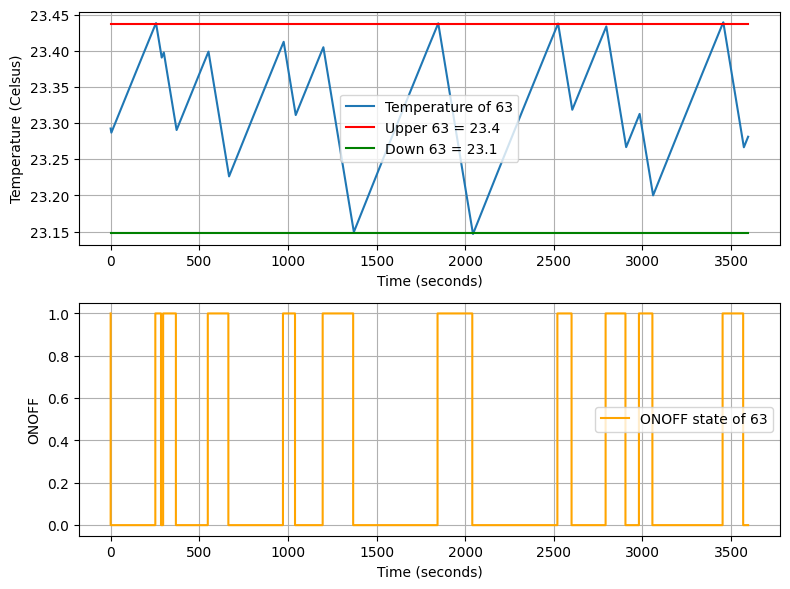

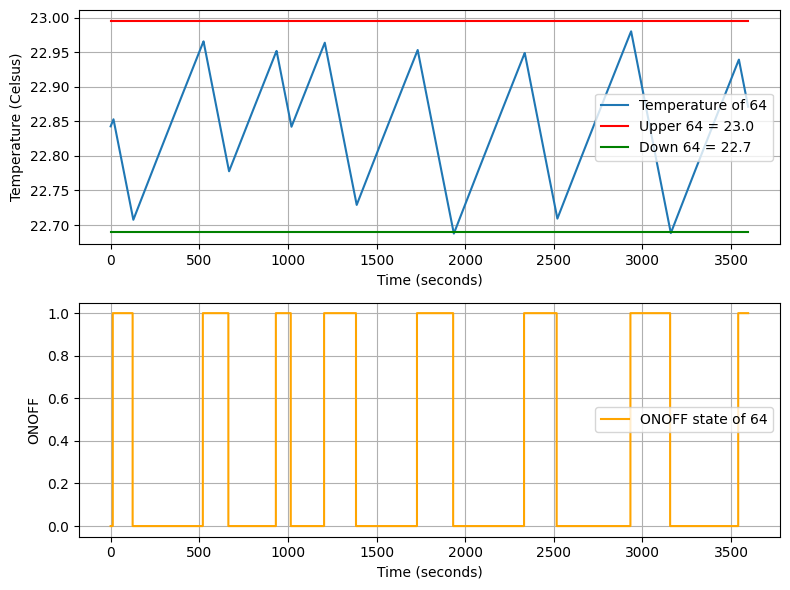

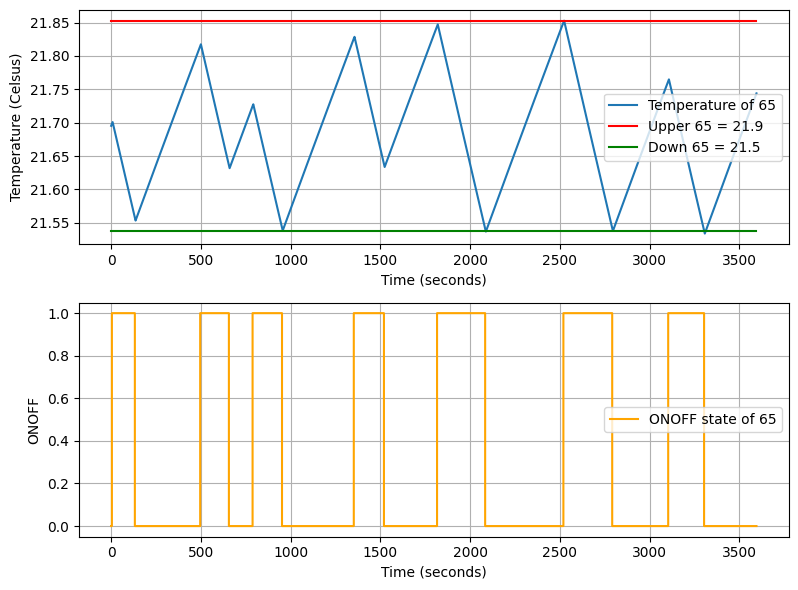

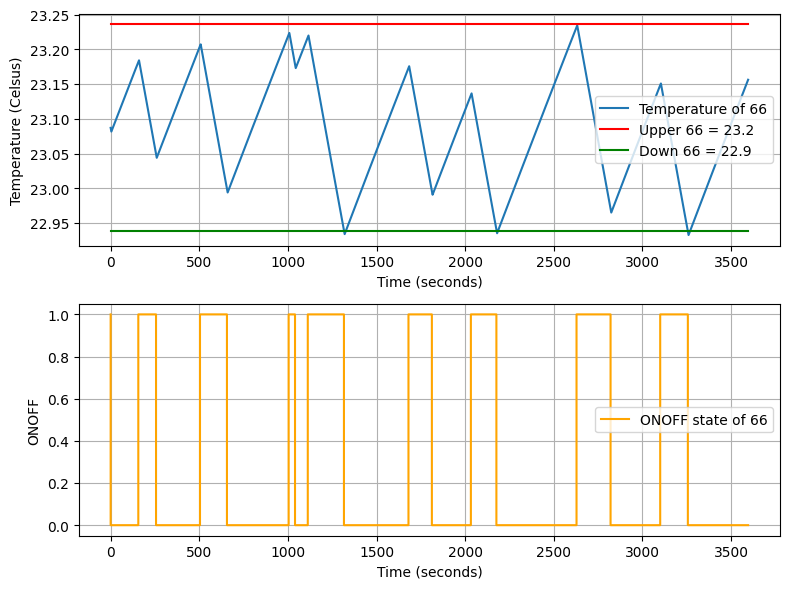

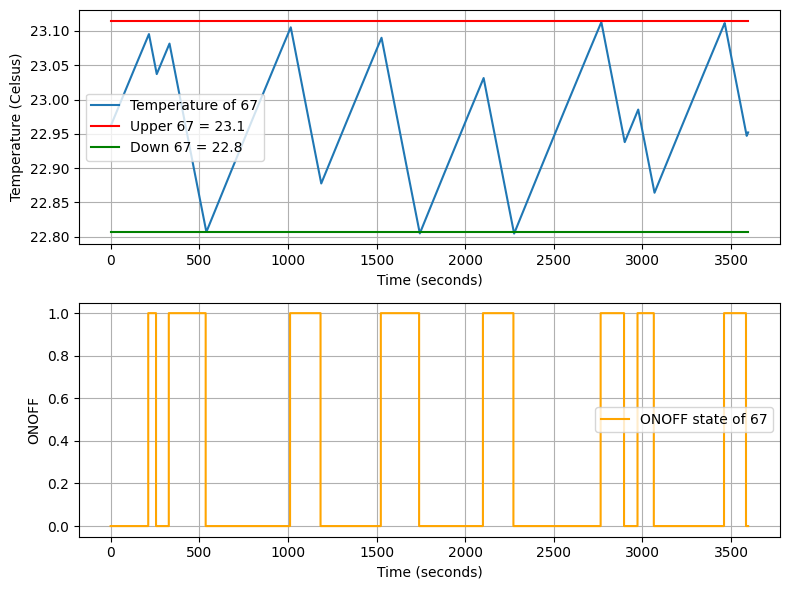

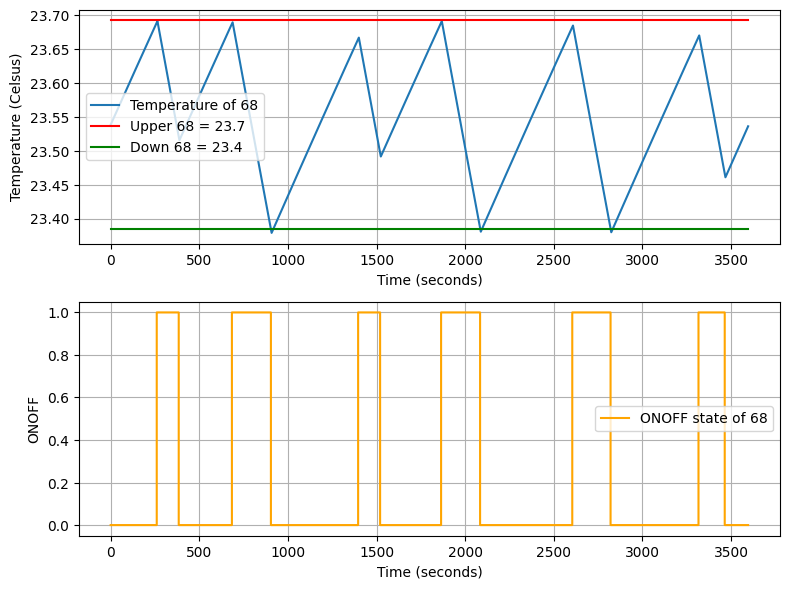

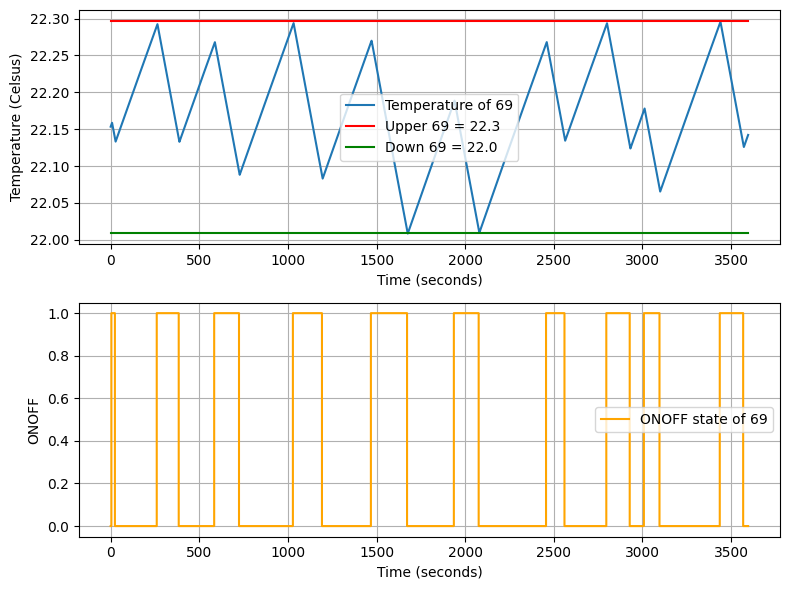

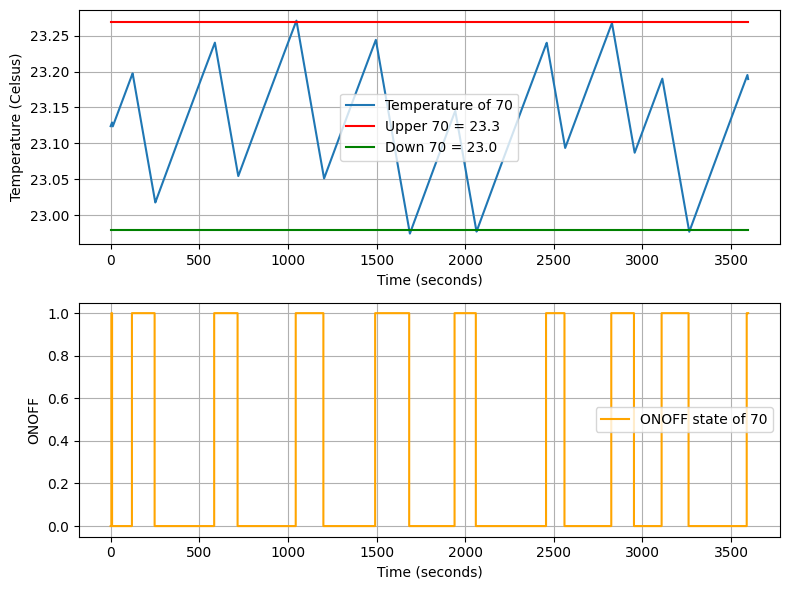

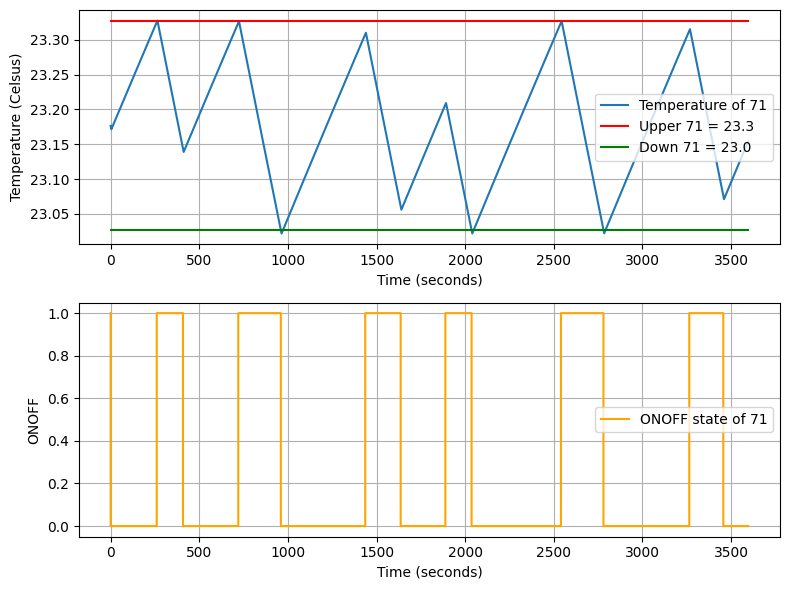

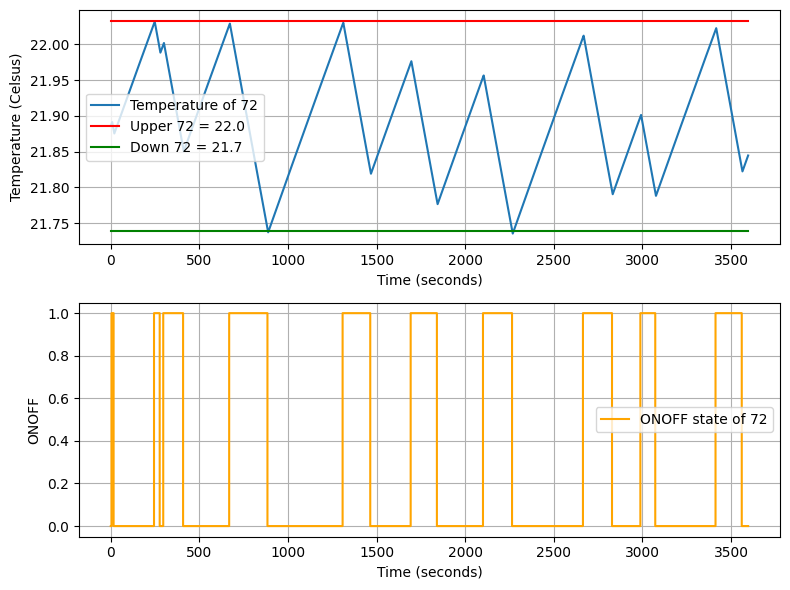

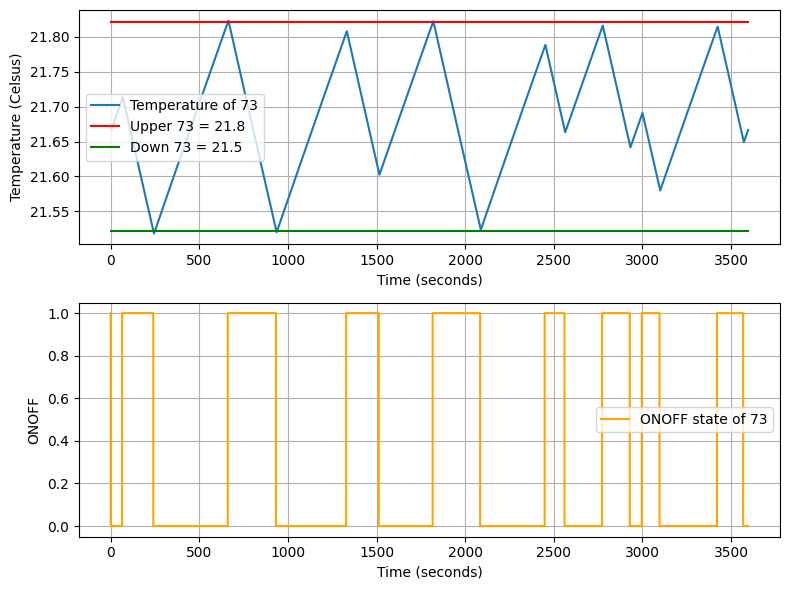

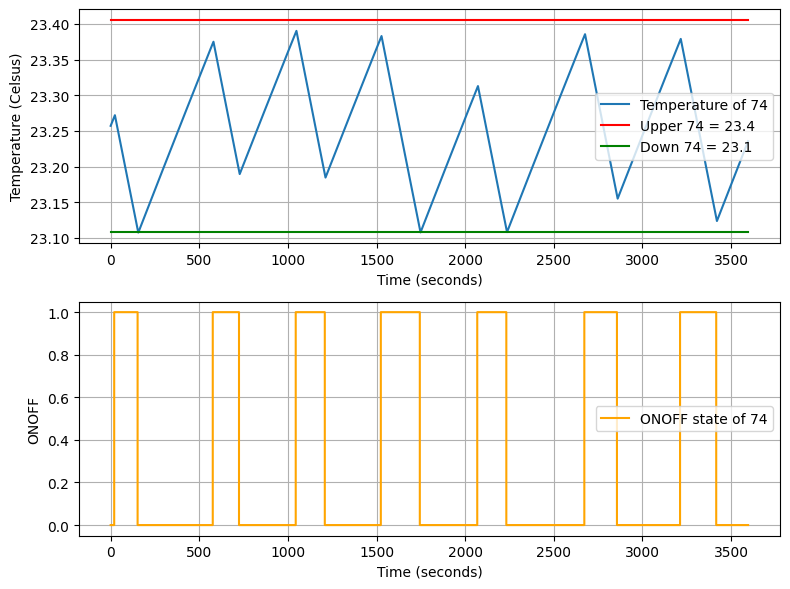

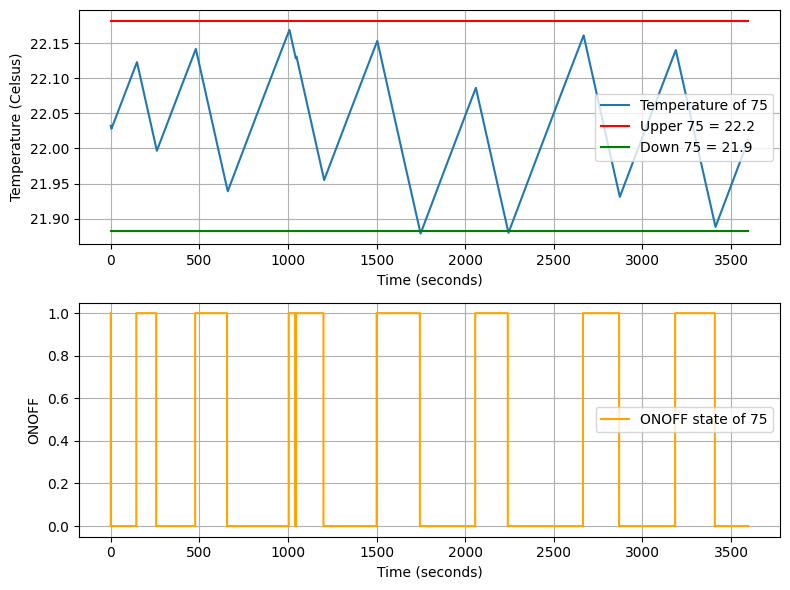

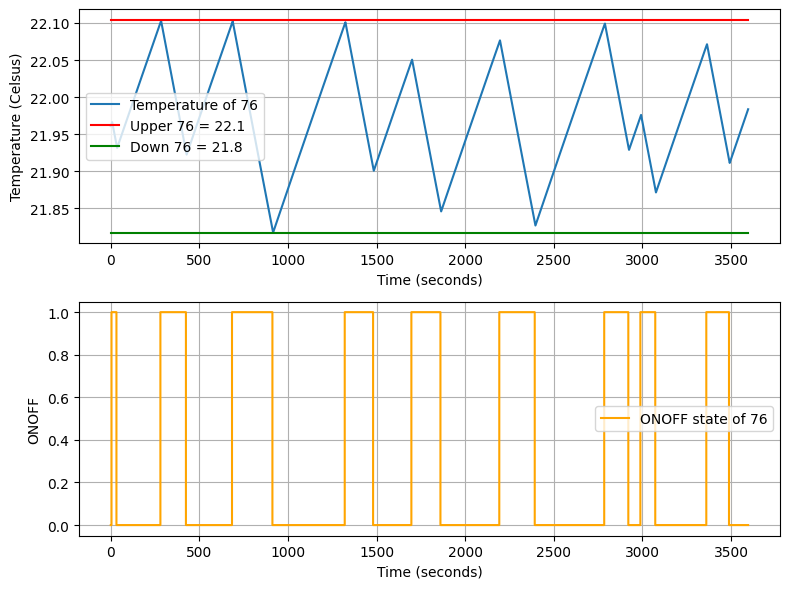

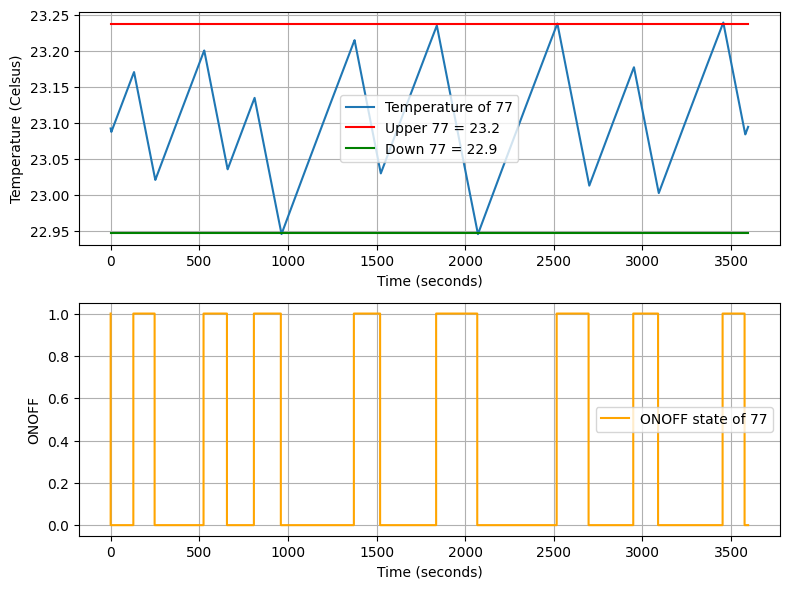

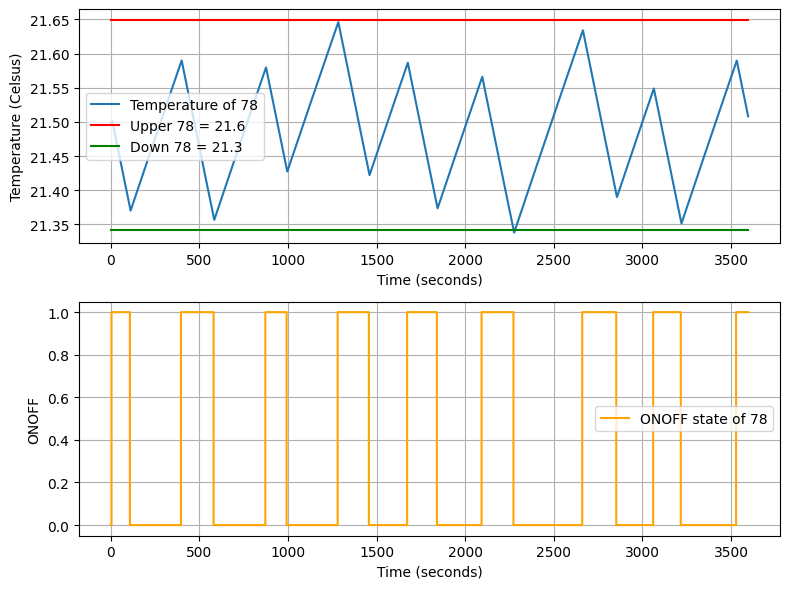

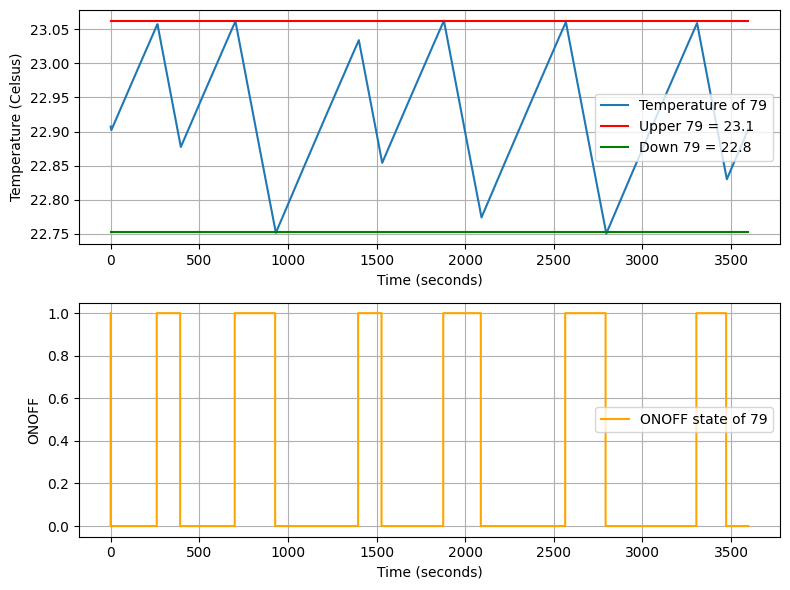

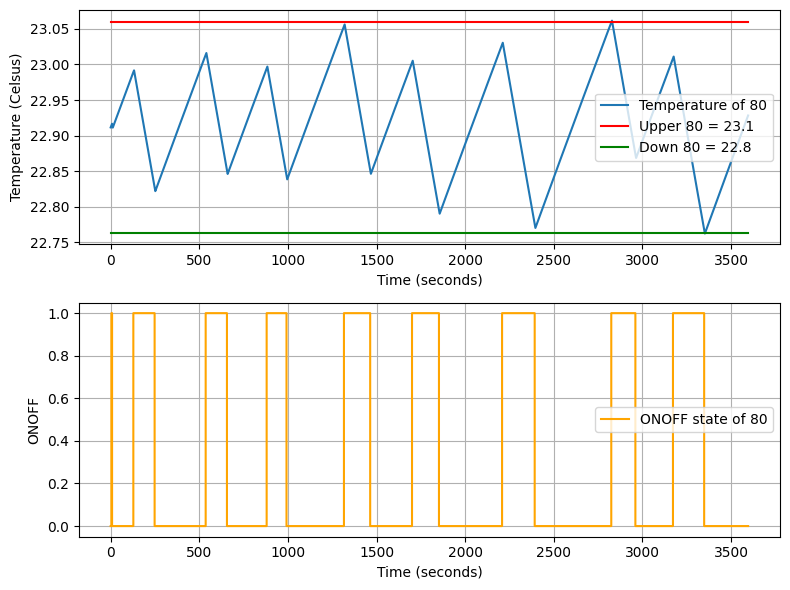

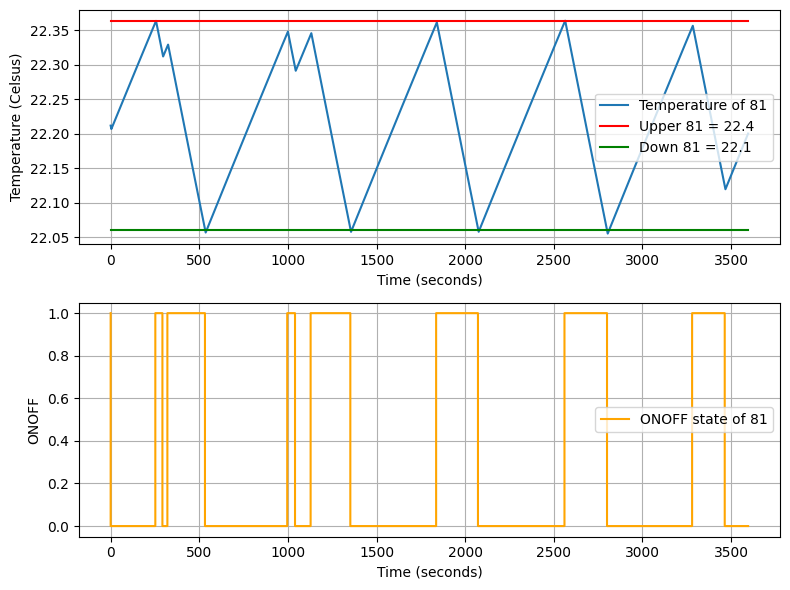

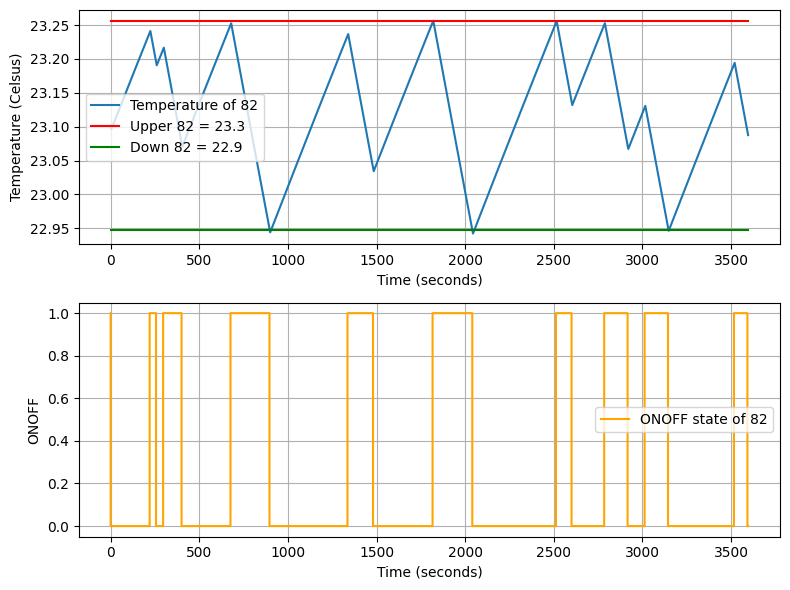

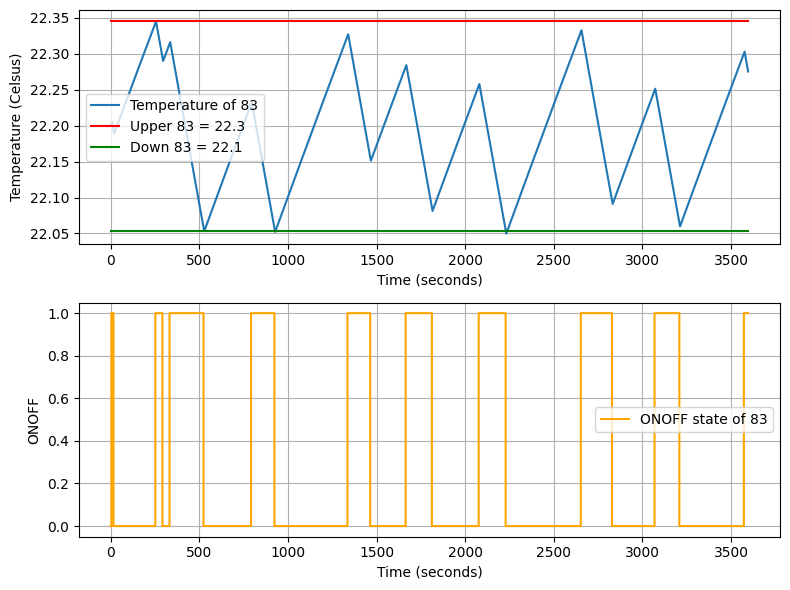

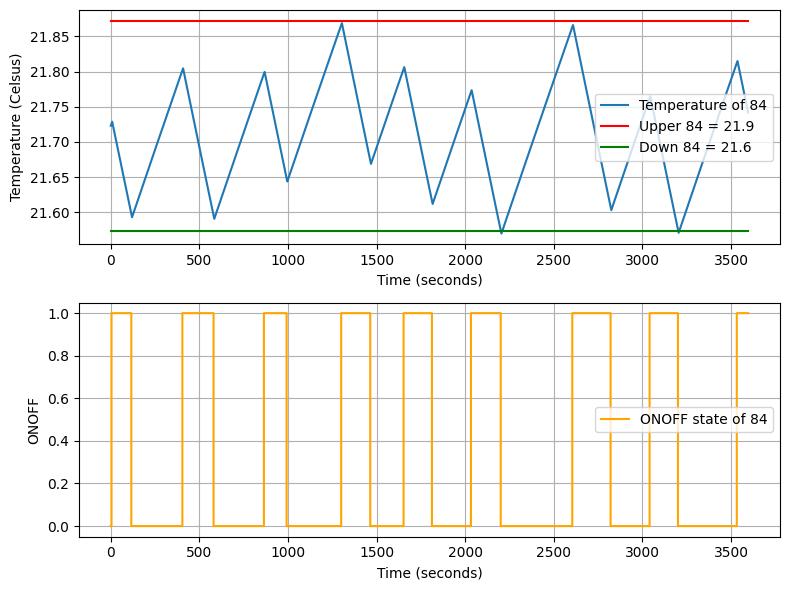

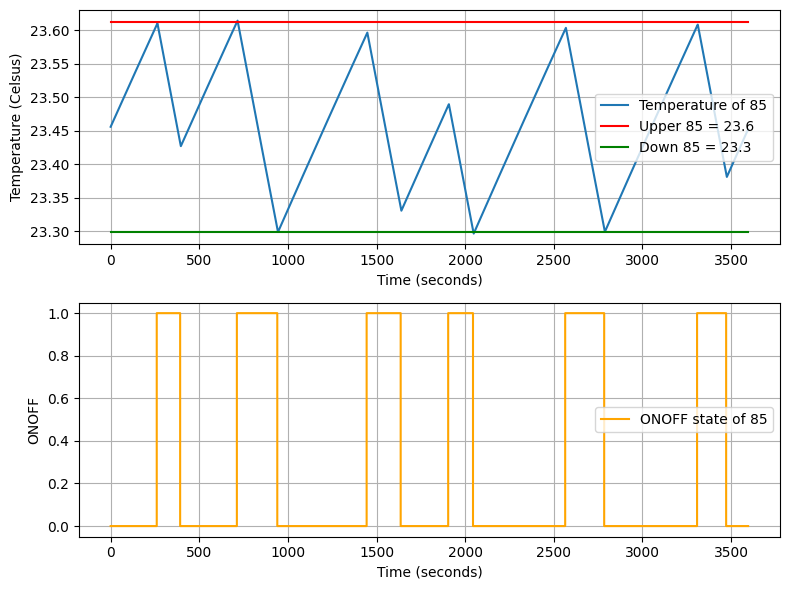

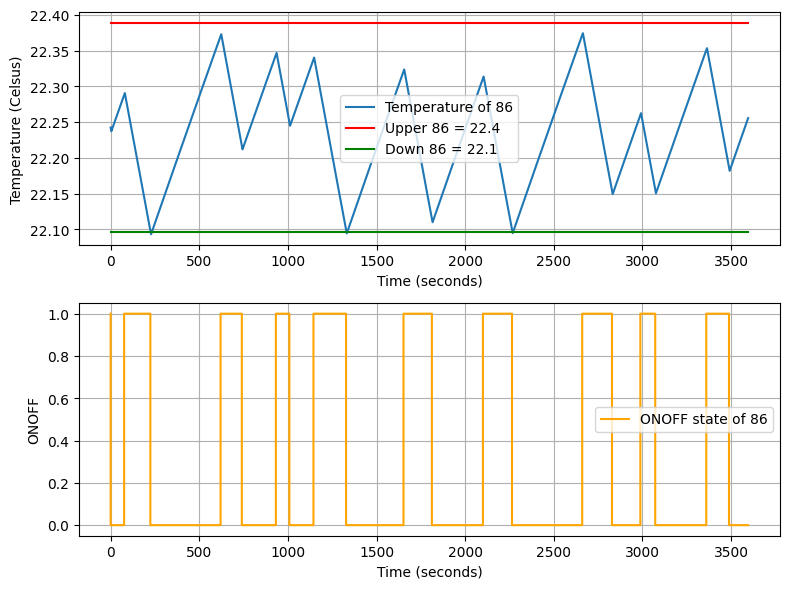

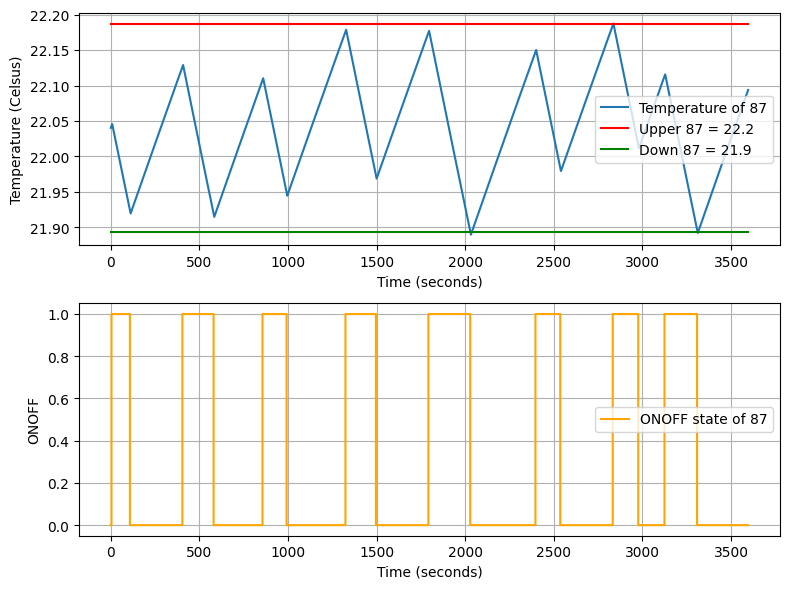

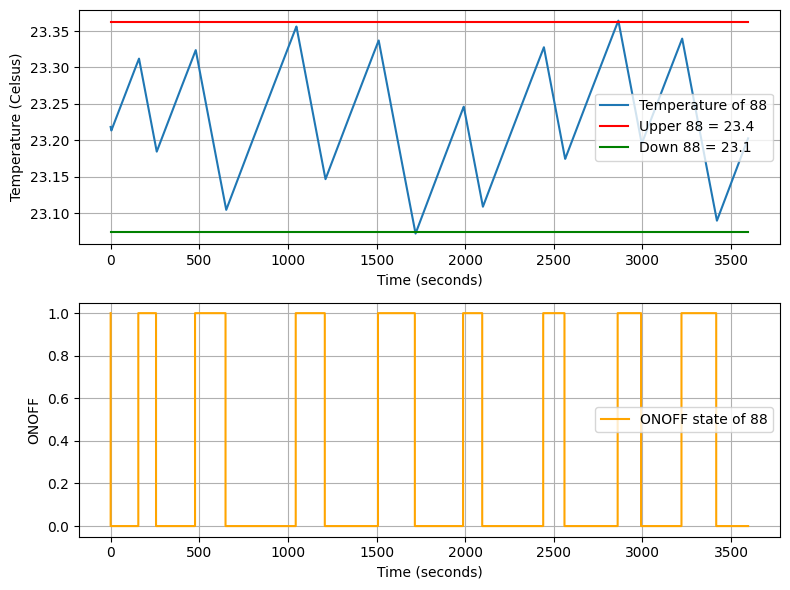

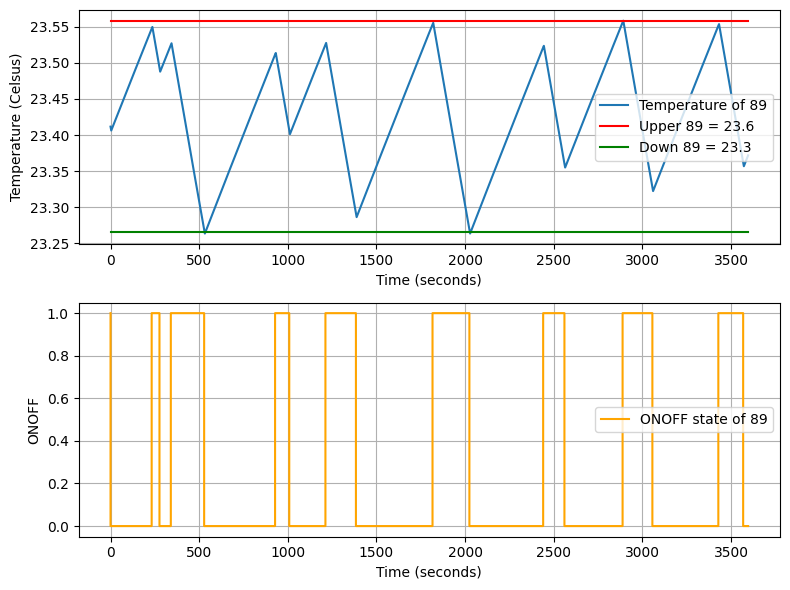

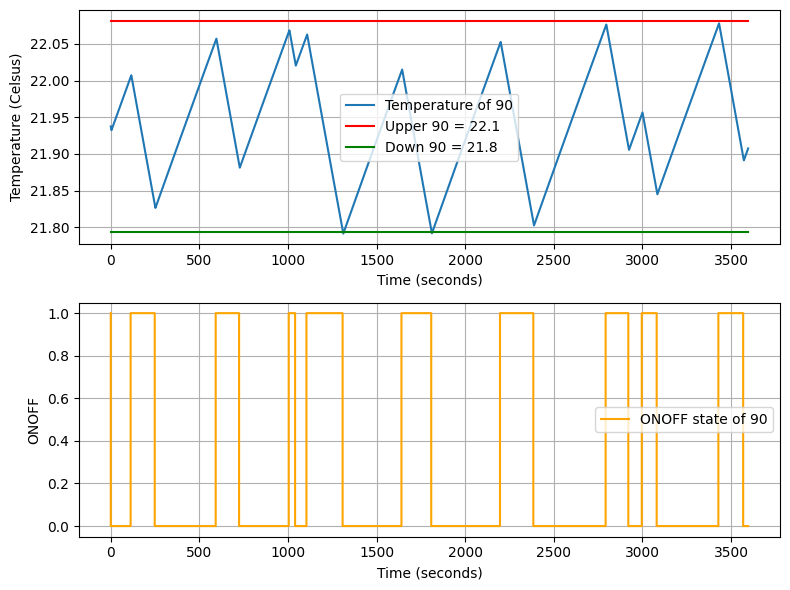

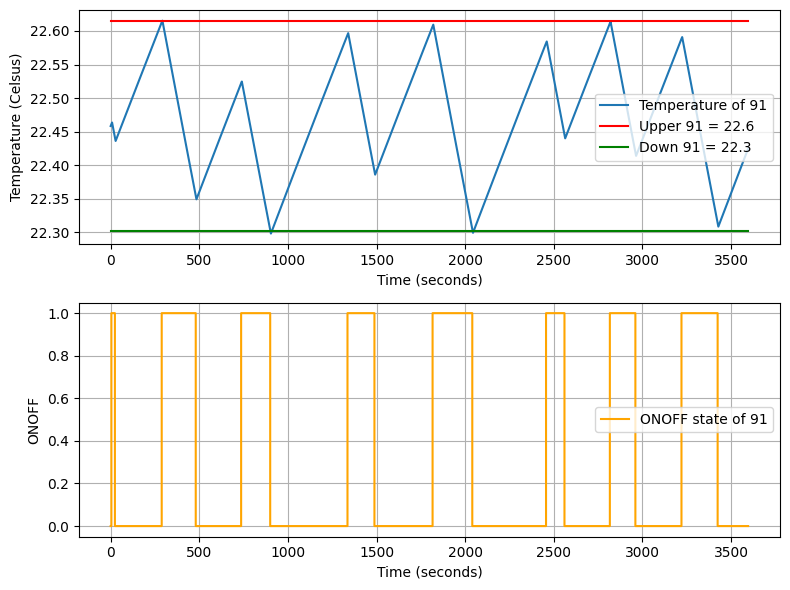

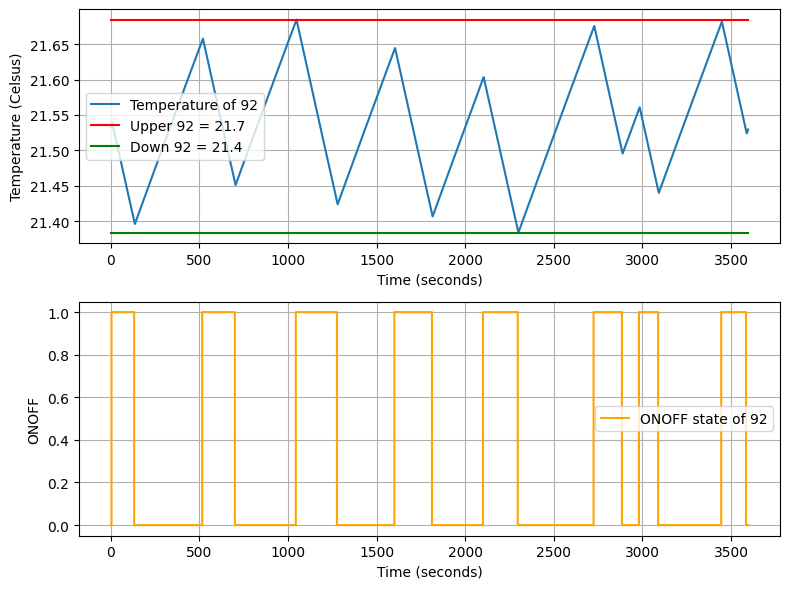

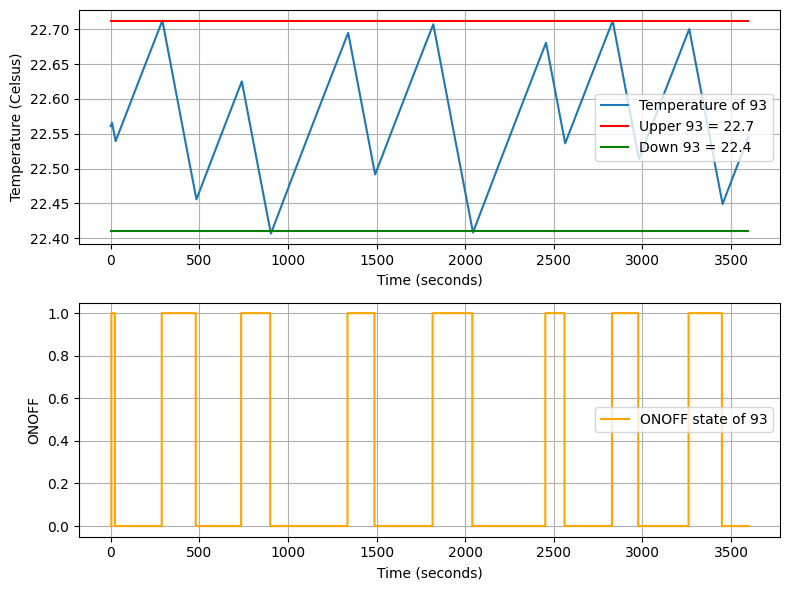

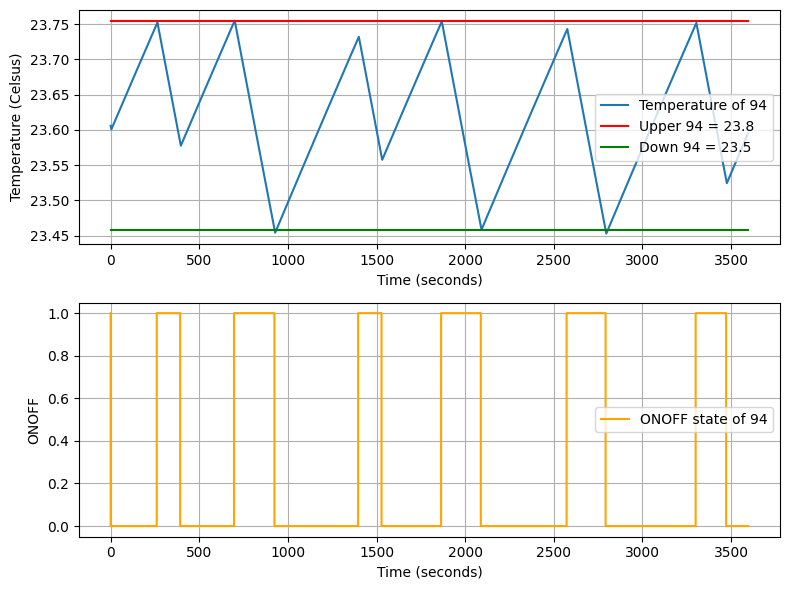

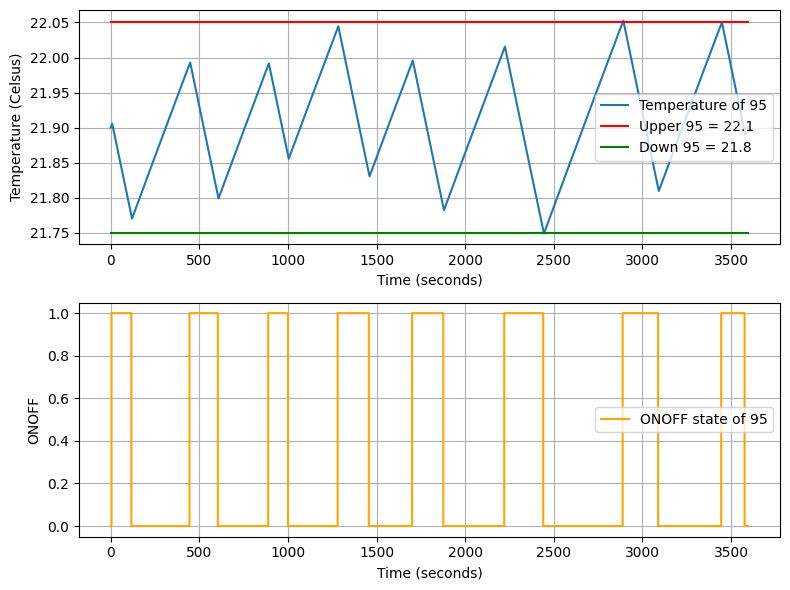

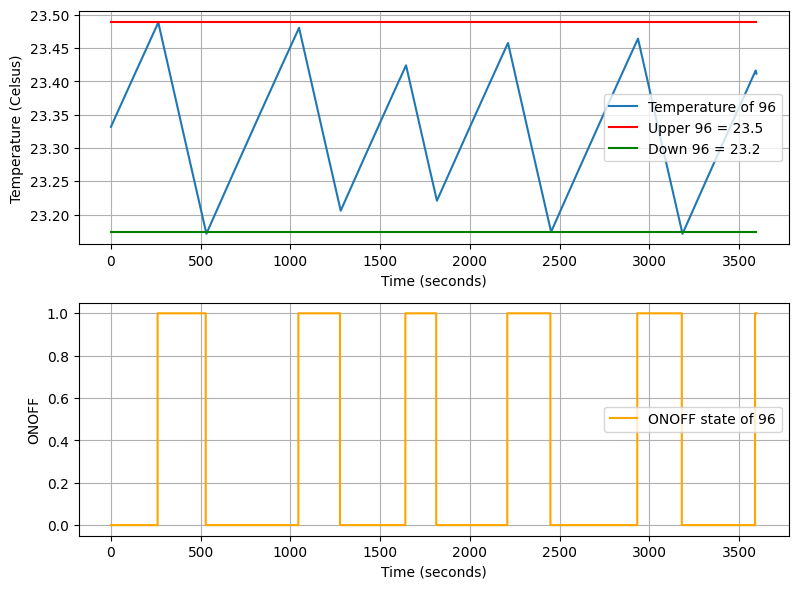

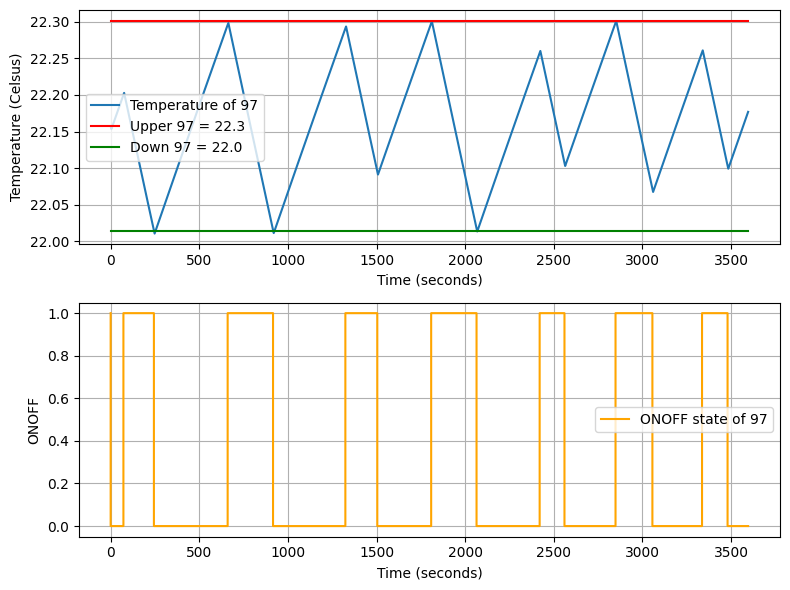

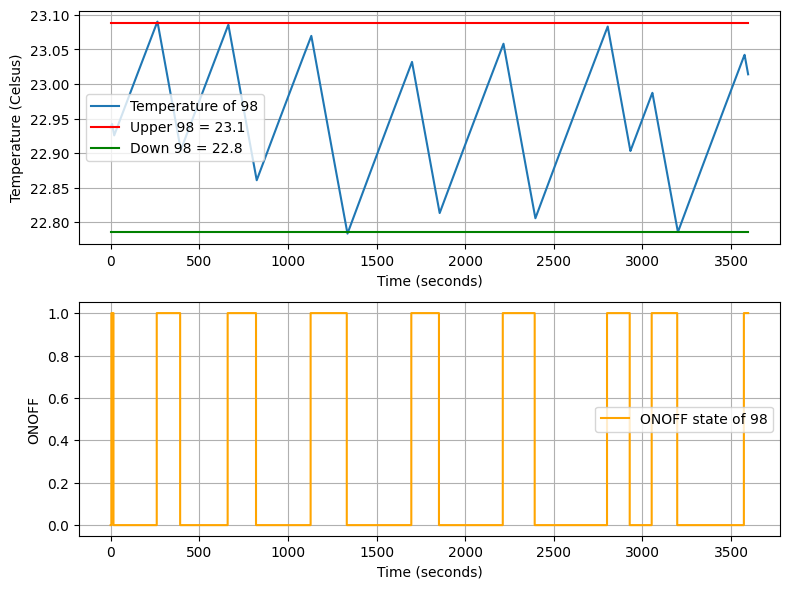

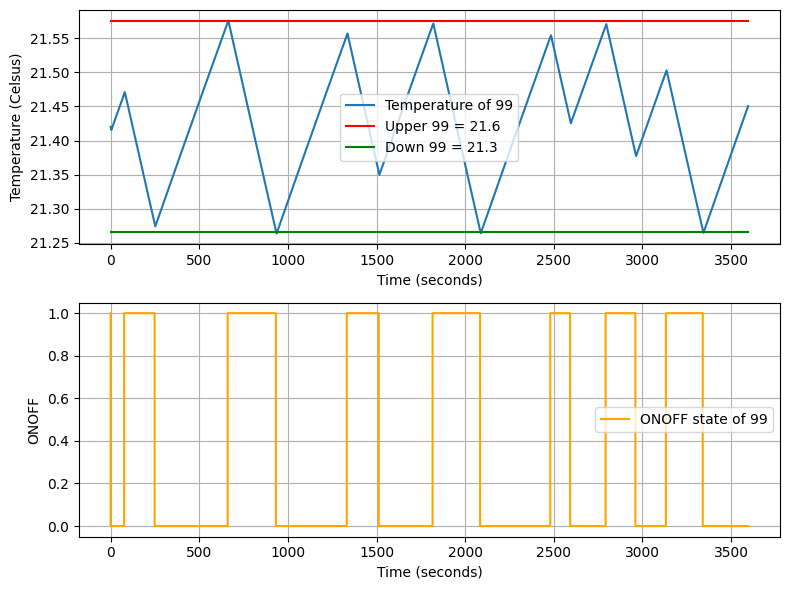

In [22]:
for i in range(100):
    TCL_plot(i)